**Second Most Frequently Seen Bird**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time


file_path = "birds_observation_data_with_index.csv"
df = pd.read_csv(file_path)

# Most frequent bird
bird_counts = df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[1]
bird_data = df[df['Bird Name'] == most_frequent_bird]
bird_trend = bird_data.groupby('Date Index')['Number of Birds'].sum()
values = bird_trend.values.astype('float32').reshape(-1, 1)
print("Most frequently seen bird:", most_frequent_bird)

print(values.mean())

# Normalization
values_log = np.log1p(values)  
values_scaled = values_log

Most frequently seen bird: Yellow-vented Bulbul
22.540697


In [2]:
window_size = 20

# Sliding Window For Multistep Forecast
def create_multistep_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size]) 
        Y.append(data[i + window_size]) 
    return np.array(X), np.array(Y)

X, Y = create_multistep_dataset(values_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to (samples, time steps, features)

c:\Users\tsimi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training time: 97.74 seconds


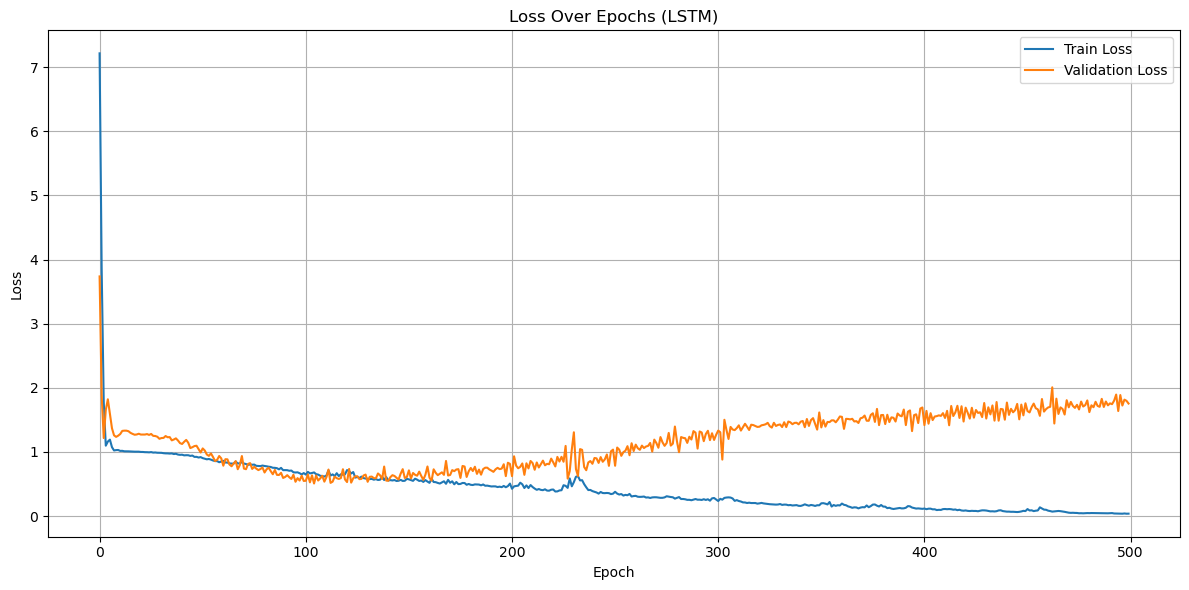

In [3]:
# Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]


start = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


history = model.fit(X_train, 
                    Y_train, 
                    epochs=500, 
                    verbose=0, 
                    validation_data=(X_test, Y_test)
                    )

print(f"Training time: {time.time() - start:.2f} seconds")


# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Save Model**

In [ ]:
# model.save('lstm_bird_model.h5')
# print("Model saved as lstm_bird_model.h5")

**Load Saved Model**

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('lstm_bird_model.h5')

# **Forecasting for Future Trend**

## **window size of 5**

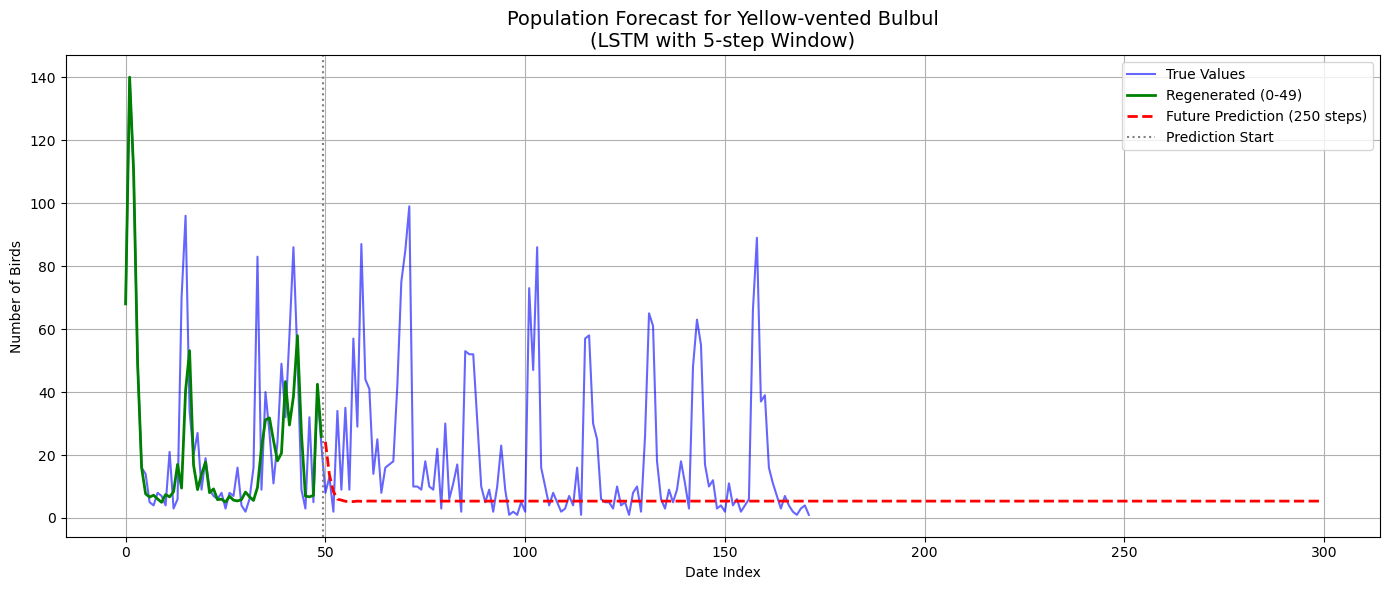

Model Performance Metrics of LSTM with 5-step Window:
MSE: 424.0247
RMSE: 20.5919
MAE: 12.1826


In [4]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []

#------------------------
# start from index 0 because before index 0, there is no historical data. So, the first window size is displayed based on the actual data.
# -----------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])

# ----------------------------------------------
# predictions for points from window_size onwards
# ----------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# ---------------------------
# Future predictions 
# ----------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# --------------------
# Ploting
# --------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

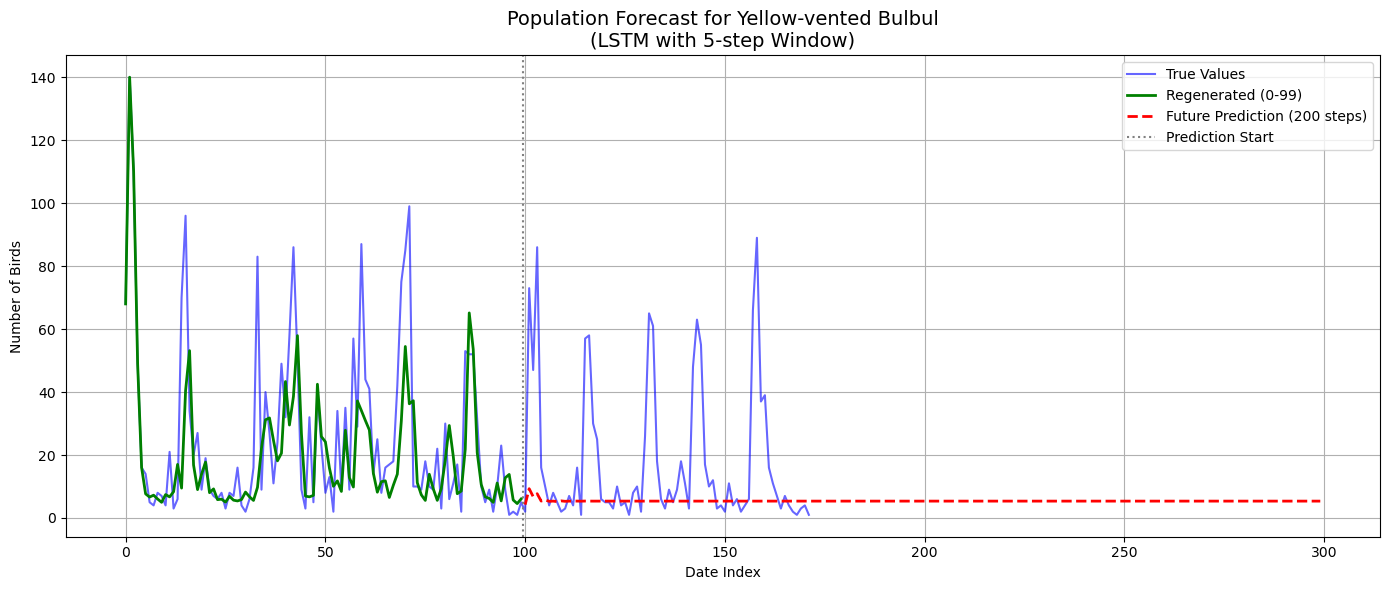

Model Performance Metrics of LSTM with 5-step Window:
MSE: 393.5196
RMSE: 19.8373
MAE: 12.5079


In [5]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []

# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------
# metrics
# -------------------------


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

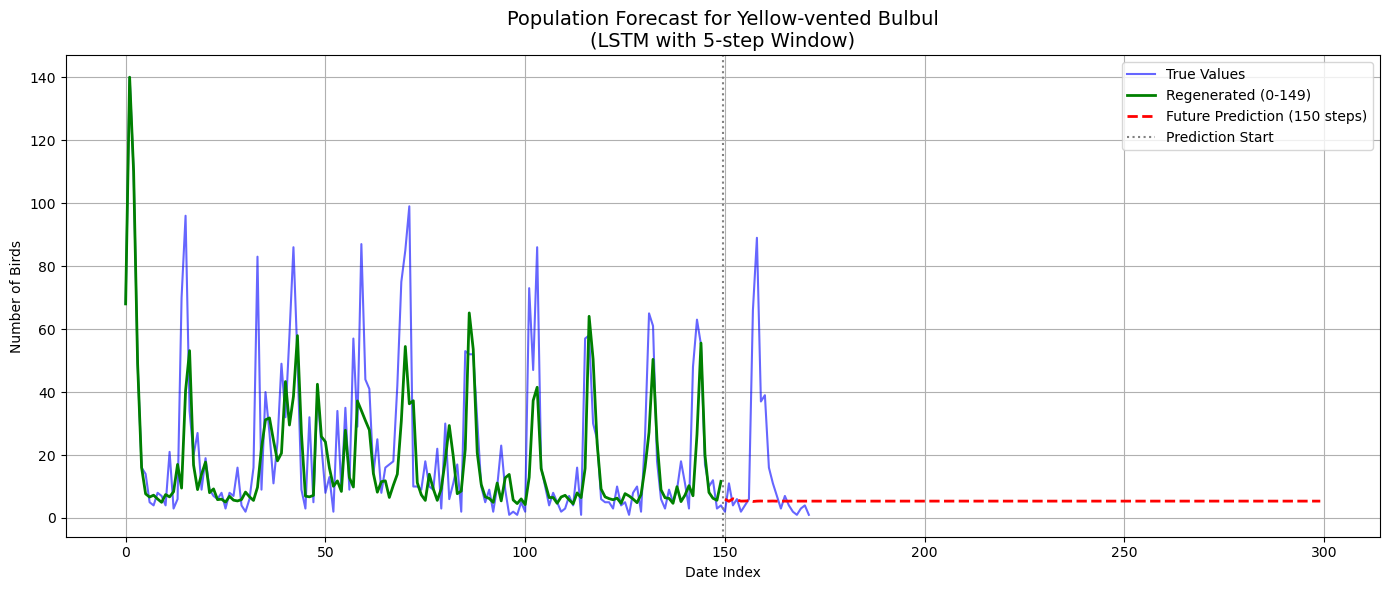

Model Performance Metrics of LSTM with 5-step Window:
MSE: 348.7823
RMSE: 18.6757
MAE: 11.2829


In [6]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []

# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------
# metrics
# -------------------------


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


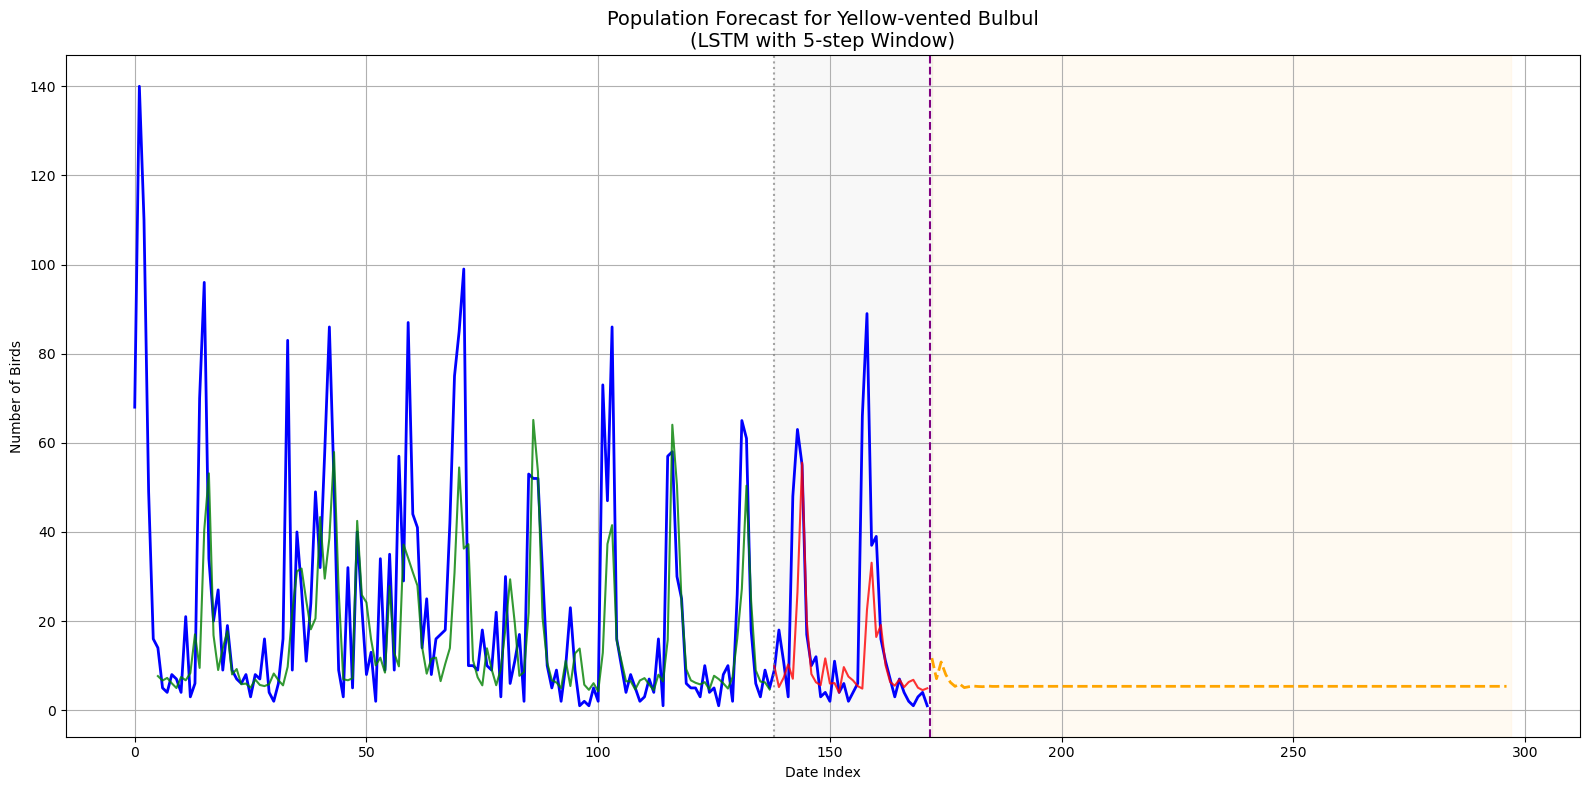


Model Performance Metrics of LSTM with 5-step Window:
Training RMSE: 18.84
Test RMSE: 18.96
Training MAE: 11.37
Test MAE: 9.54


In [7]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [8]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 11.70
Step 2: 7.07
Step 3: 10.82
Step 4: 8.00
Step 5: 6.25
Step 6: 5.35
Step 7: 5.88
Step 8: 5.07
Step 9: 5.27
Step 10: 5.41
Step 11: 5.32
Step 12: 5.28
Step 13: 5.44
Step 14: 5.34
Step 15: 5.34
Step 16: 5.39
Step 17: 5.36
Step 18: 5.34
Step 19: 5.37
Step 20: 5.36
Step 21: 5.35
Step 22: 5.36
Step 23: 5.36
Step 24: 5.35
Step 25: 5.36
Step 26: 5.36
Step 27: 5.36
Step 28: 5.36
Step 29: 5.36
Step 30: 5.36
Step 31: 5.36
Step 32: 5.36
Step 33: 5.36
Step 34: 5.36
Step 35: 5.36
Step 36: 5.36
Step 37: 5.36
Step 38: 5.36
Step 39: 5.36
Step 40: 5.36
Step 41: 5.36
Step 42: 5.36
Step 43: 5.36
Step 44: 5.36
Step 45: 5.36
Step 46: 5.36
Step 47: 5.36
Step 48: 5.36
Step 49: 5.36
Step 50: 5.36
Step 51: 5.36
Step 52: 5.36
Step 53: 5.36
Step 54: 5.36
Step 55: 5.36
Step 56: 5.36
Step 57: 5.36
Step 58: 5.36
Step 59: 5.36
Step 60: 5.36
Step 61: 5.36
Step 62: 5.36
Step 63: 5.36
Step 64: 5.36
Step 65: 5.36
Step 66: 5.36
Step 67: 5.36
Step 68: 5.36
Step 69: 5.36
Step 70: 

## **window size of 10**

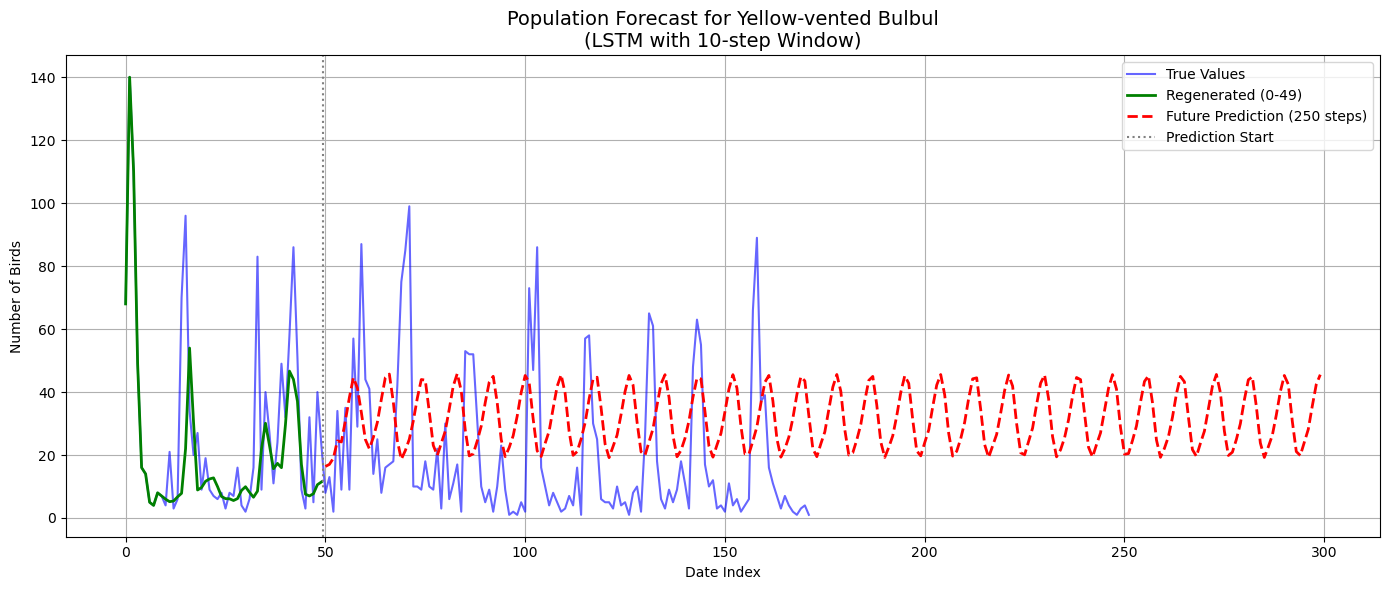

Model Performance Metrics of LSTM with 10-step Window:
MSE: 540.5897
RMSE: 23.2506
MAE: 14.1166


In [11]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

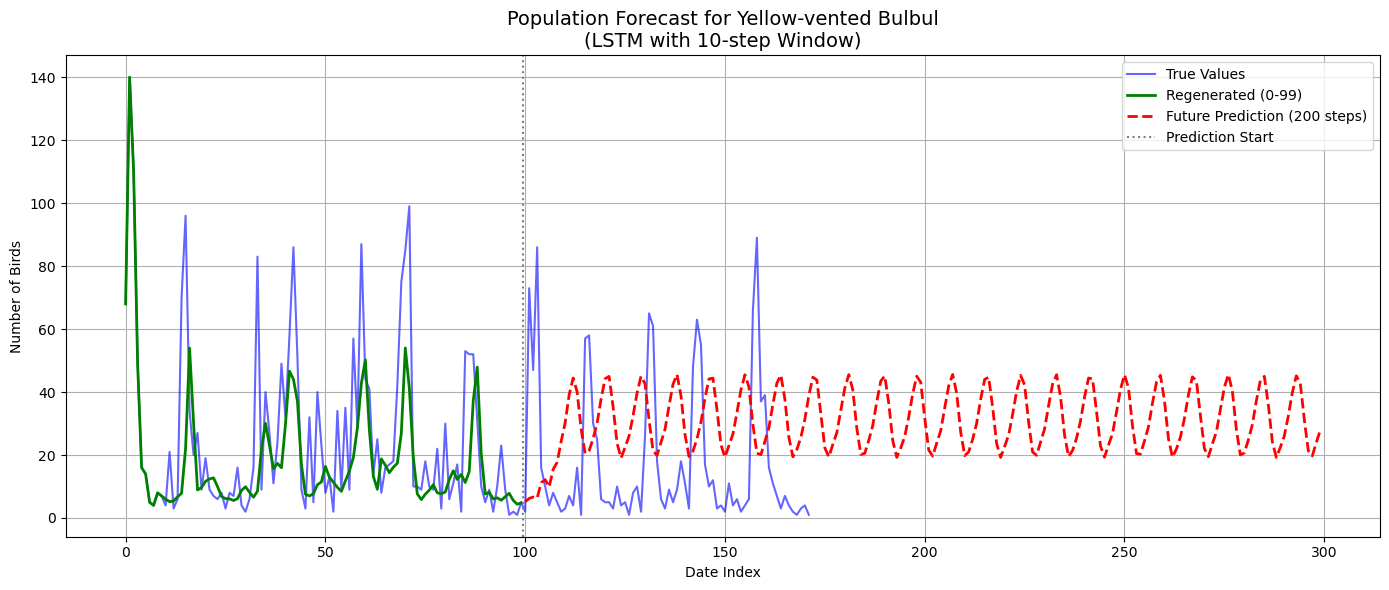

Model Performance Metrics of LSTM with 10-step Window:
MSE: 437.9072
RMSE: 20.9262
MAE: 13.2591


In [12]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

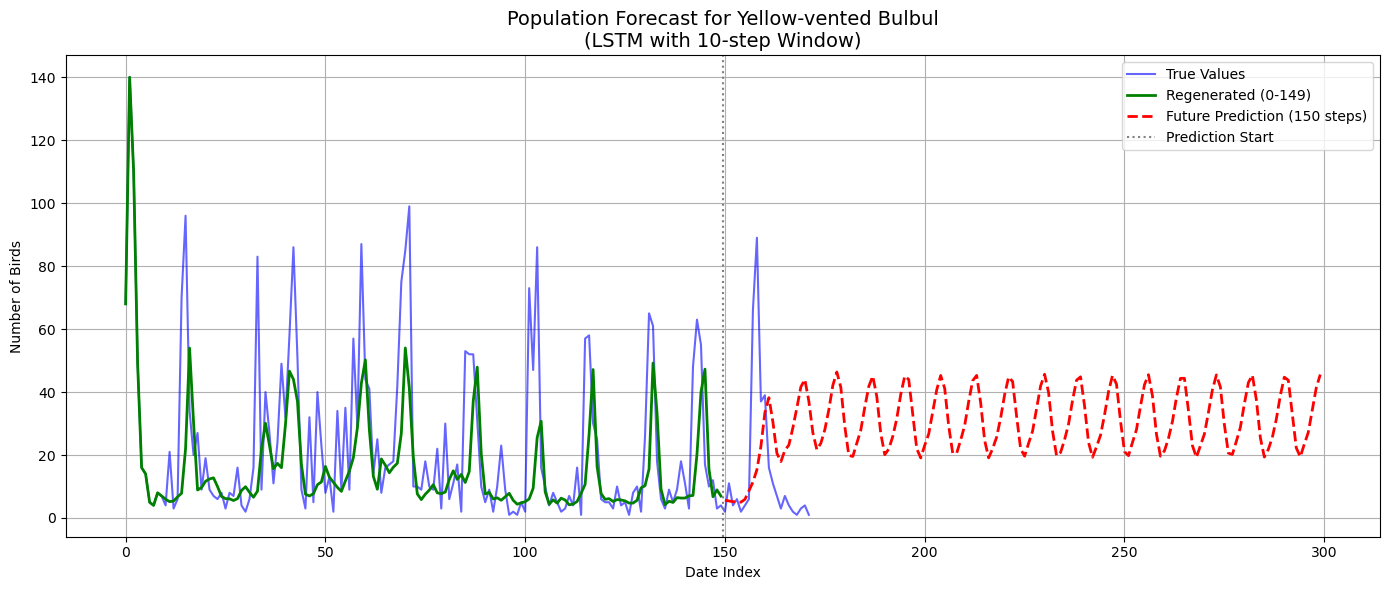

Model Performance Metrics of LSTM with 10-step Window:
MSE: 435.9703
RMSE: 20.8799
MAE: 12.9668


In [13]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


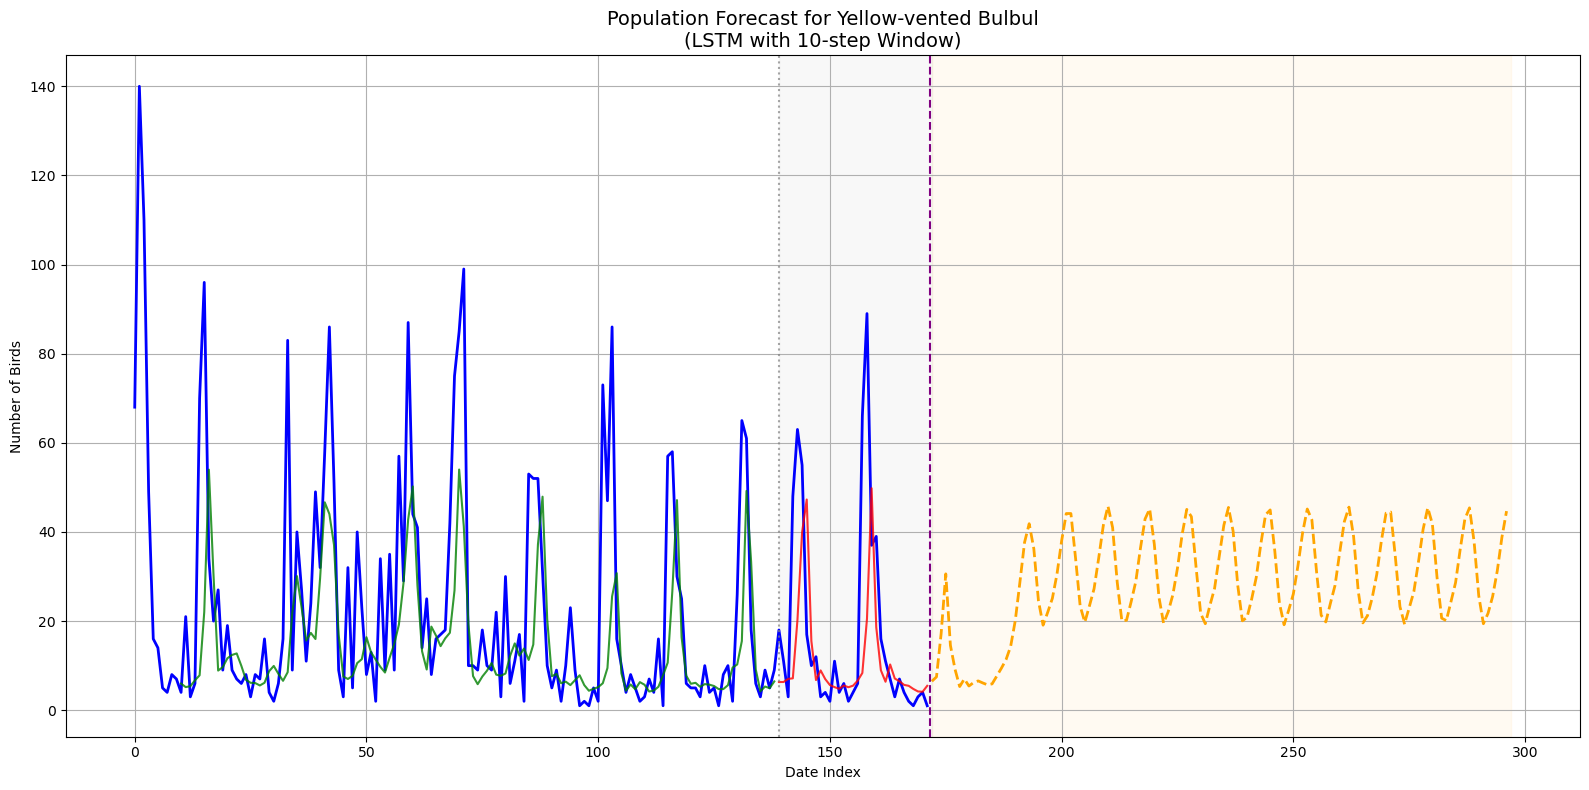


Model Performance Metrics of LSTM with 10-step Window:
Training RMSE: 20.86
Test RMSE: 20.39
Training MAE: 12.76
Test MAE: 11.47


In [14]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [15]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 6.50
Step 2: 7.48
Step 3: 17.17
Step 4: 30.59
Step 5: 14.57
Step 6: 9.18
Step 7: 5.30
Step 8: 7.01
Step 9: 5.42
Step 10: 6.21
Step 11: 6.57
Step 12: 6.11
Step 13: 5.69
Step 14: 5.91
Step 15: 7.65
Step 16: 9.42
Step 17: 11.34
Step 18: 14.31
Step 19: 20.13
Step 20: 28.75
Step 21: 37.66
Step 22: 41.85
Step 23: 36.25
Step 24: 24.54
Step 25: 19.08
Step 26: 21.99
Step 27: 25.09
Step 28: 30.55
Step 29: 38.01
Step 30: 44.13
Step 31: 44.13
Step 32: 34.17
Step 33: 23.36
Step 34: 19.74
Step 35: 23.40
Step 36: 27.26
Step 37: 34.15
Step 38: 41.49
Step 39: 45.79
Step 40: 41.00
Step 41: 28.67
Step 42: 20.02
Step 43: 20.19
Step 44: 24.34
Step 45: 28.86
Step 46: 36.30
Step 47: 42.91
Step 48: 45.17
Step 49: 37.23
Step 50: 25.36
Step 51: 19.51
Step 52: 22.11
Step 53: 25.91
Step 54: 31.90
Step 55: 39.44
Step 56: 45.07
Step 57: 43.43
Step 58: 32.17
Step 59: 21.73
Step 60: 19.41
Step 61: 23.53
Step 62: 27.33
Step 63: 34.46
Step 64: 41.49
Step 65: 45.50
Step 66: 40.19


## **window size of 20**

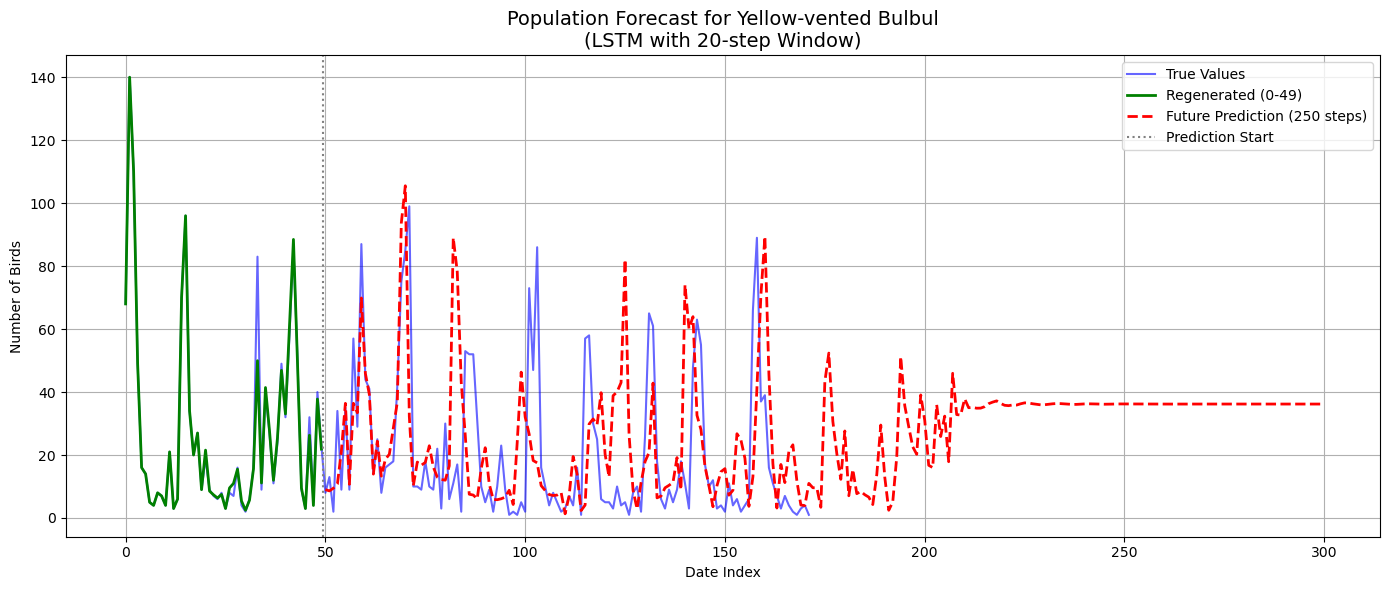

Model Performance Metrics of LSTM with 20-step Window:
MSE: 39.6736
RMSE: 6.2987
MAE: 2.4228


In [34]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

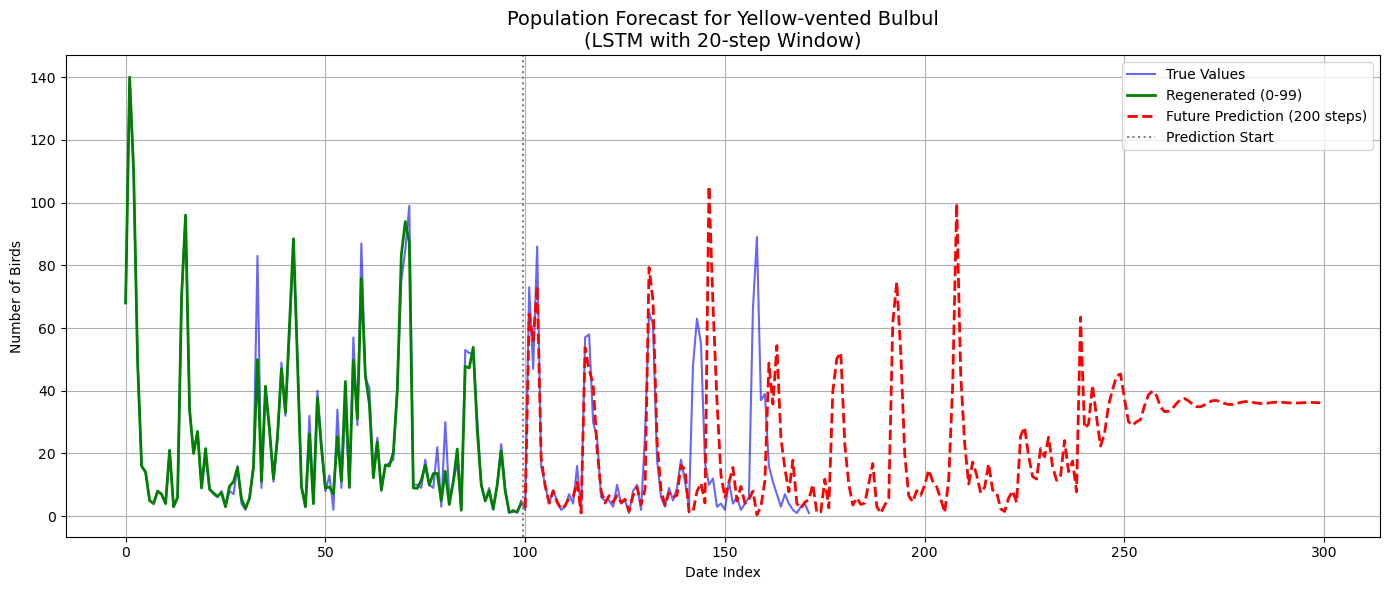

Model Performance Metrics of LSTM with 20-step Window:
MSE: 29.2095
RMSE: 5.4046
MAE: 2.9099


In [35]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

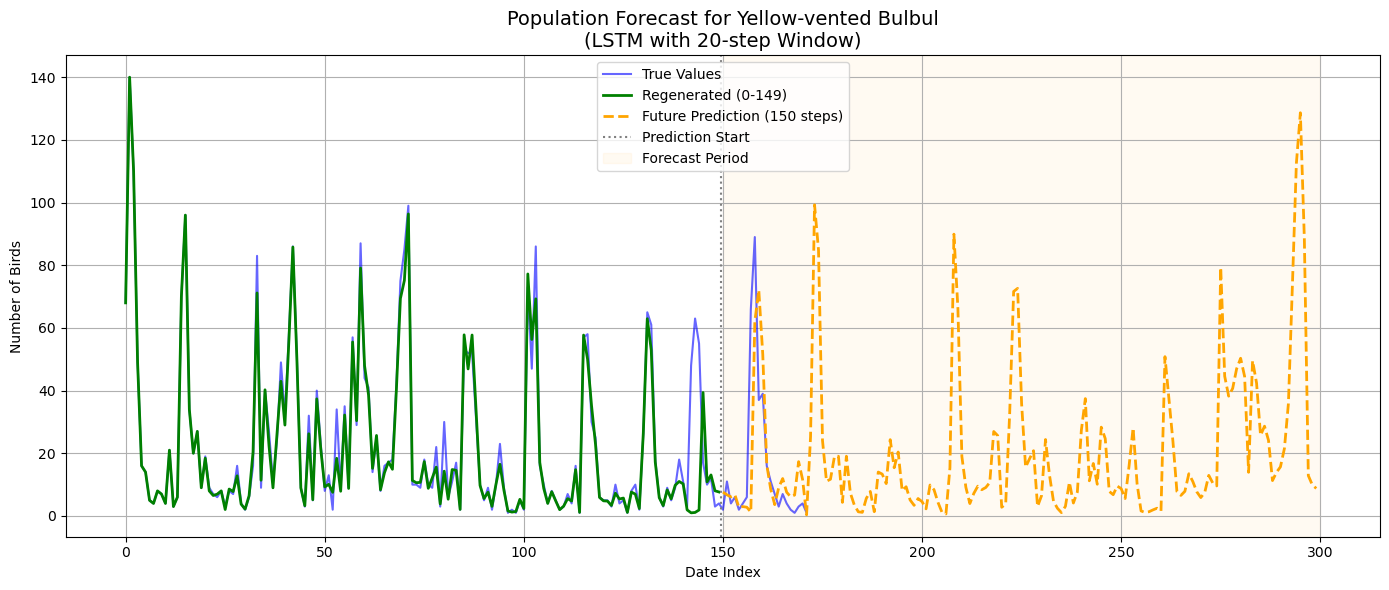

Model Performance Metrics of LSTM with 20-step Window:
MSE: 87.1359
RMSE: 9.3347
MAE: 3.7185
MAPE: 19.85%


In [5]:
from sklearn.metrics import mean_absolute_percentage_error

regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


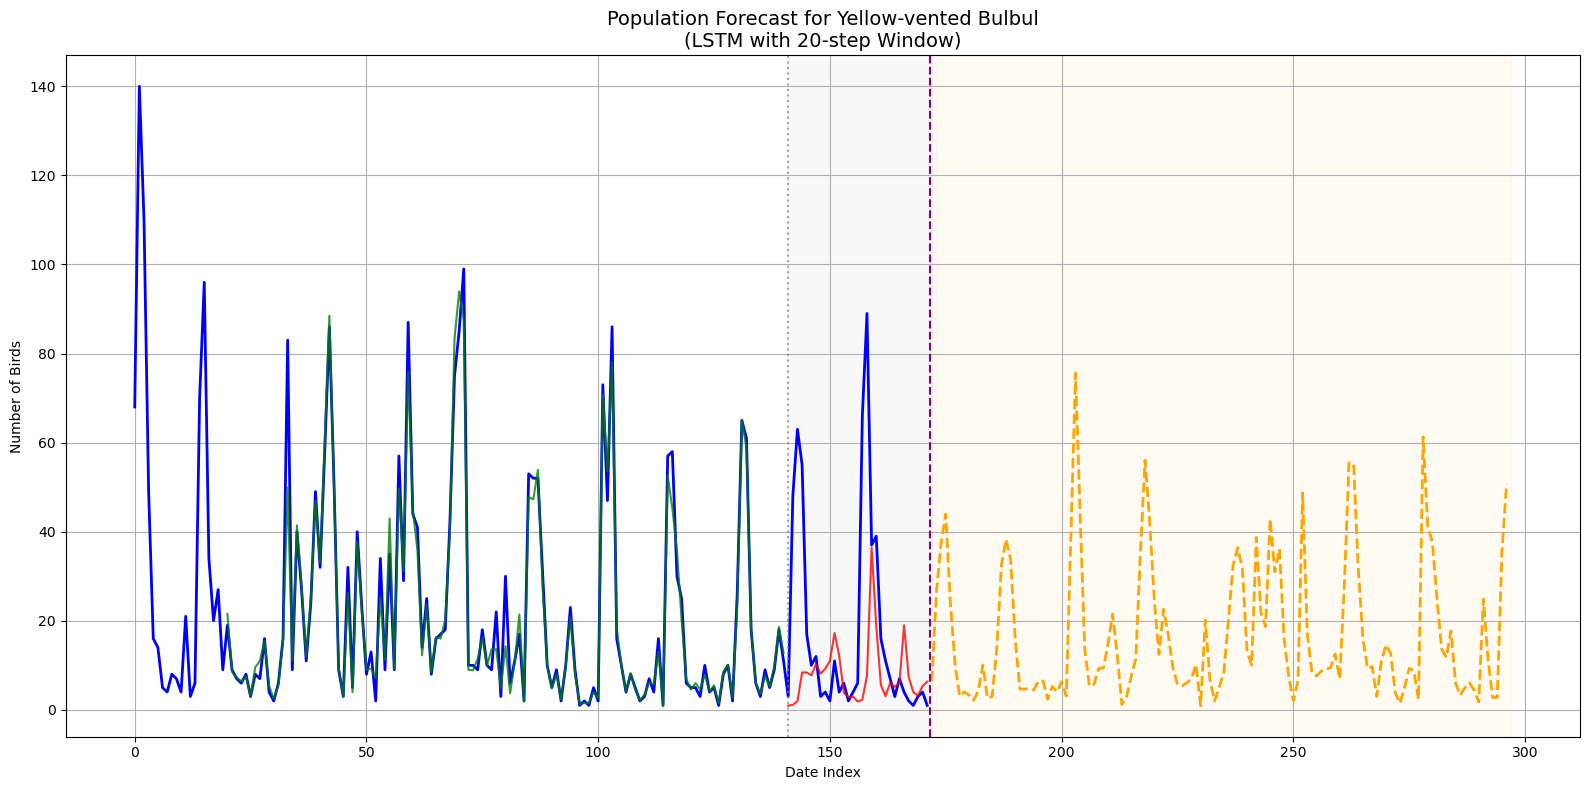


Model Performance Metrics of LSTM with {window_size}-step Window:
Training RMSE: 4.75
Test RMSE: 25.40
Training MAE: 2.54
Test MAE: 13.86


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [38]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 6.48
Step 2: 26.73
Step 3: 37.52
Step 4: 43.95
Step 5: 23.87
Step 6: 10.24
Step 7: 3.09
Step 8: 4.06
Step 9: 3.32
Step 10: 2.15
Step 11: 4.17
Step 12: 10.08
Step 13: 2.63
Step 14: 2.97
Step 15: 13.58
Step 16: 32.44
Step 17: 38.30
Step 18: 33.71
Step 19: 15.67
Step 20: 4.68
Step 21: 4.67
Step 22: 4.73
Step 23: 4.49
Step 24: 6.46
Step 25: 6.47
Step 26: 2.37
Step 27: 5.24
Step 28: 4.05
Step 29: 6.27
Step 30: 3.14
Step 31: 39.14
Step 32: 75.61
Step 33: 43.55
Step 34: 13.51
Step 35: 5.28
Step 36: 5.79
Step 37: 9.29
Step 38: 9.41
Step 39: 14.70
Step 40: 21.51
Step 41: 12.30
Step 42: 1.21
Step 43: 2.87
Step 44: 7.52
Step 45: 11.44
Step 46: 35.36
Step 47: 56.03
Step 48: 42.22
Step 49: 24.67
Step 50: 12.46
Step 51: 22.59
Step 52: 16.89
Step 53: 9.54
Step 54: 5.71
Step 55: 5.41
Step 56: 6.06
Step 57: 7.00
Step 58: 10.21
Step 59: 0.93
Step 60: 20.14
Step 61: 6.75
Step 62: 1.98
Step 63: 5.07
Step 64: 8.41
Step 65: 20.26
Step 66: 32.57
Step 67: 36.41
Step 68:

## **Window Size of 25**

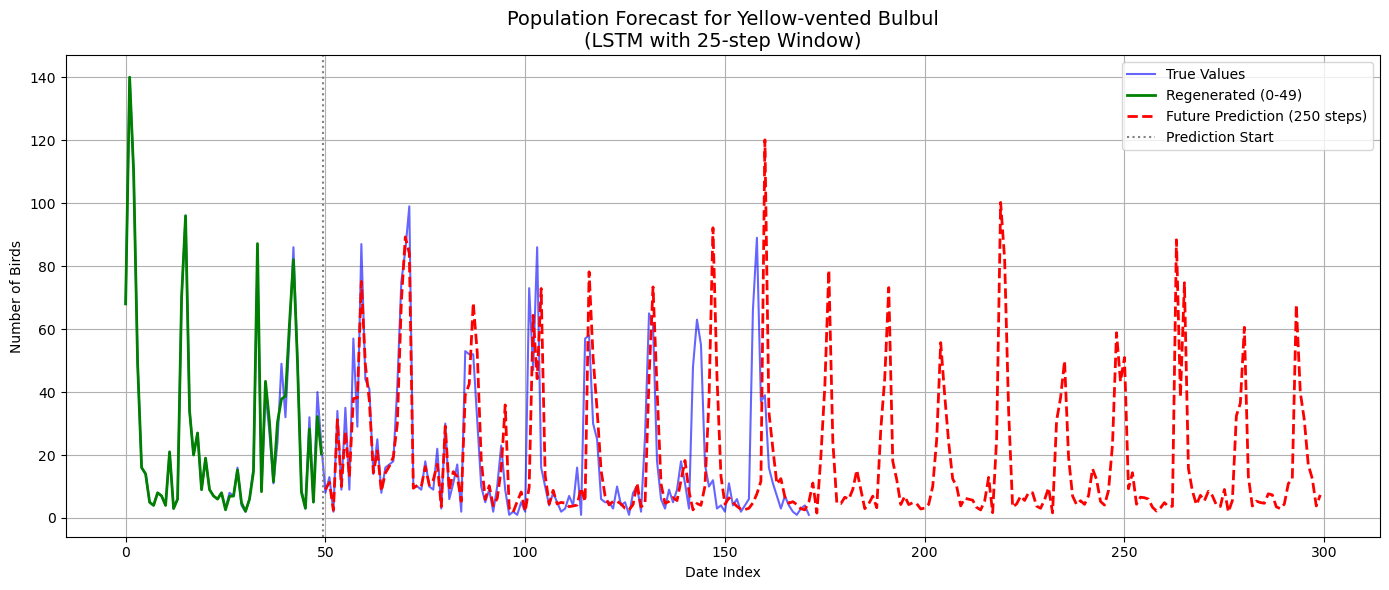

Model Performance Metrics of LSTM with 25-step Window:
MSE: 14.7163
RMSE: 3.8362
MAE: 2.5901


In [27]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

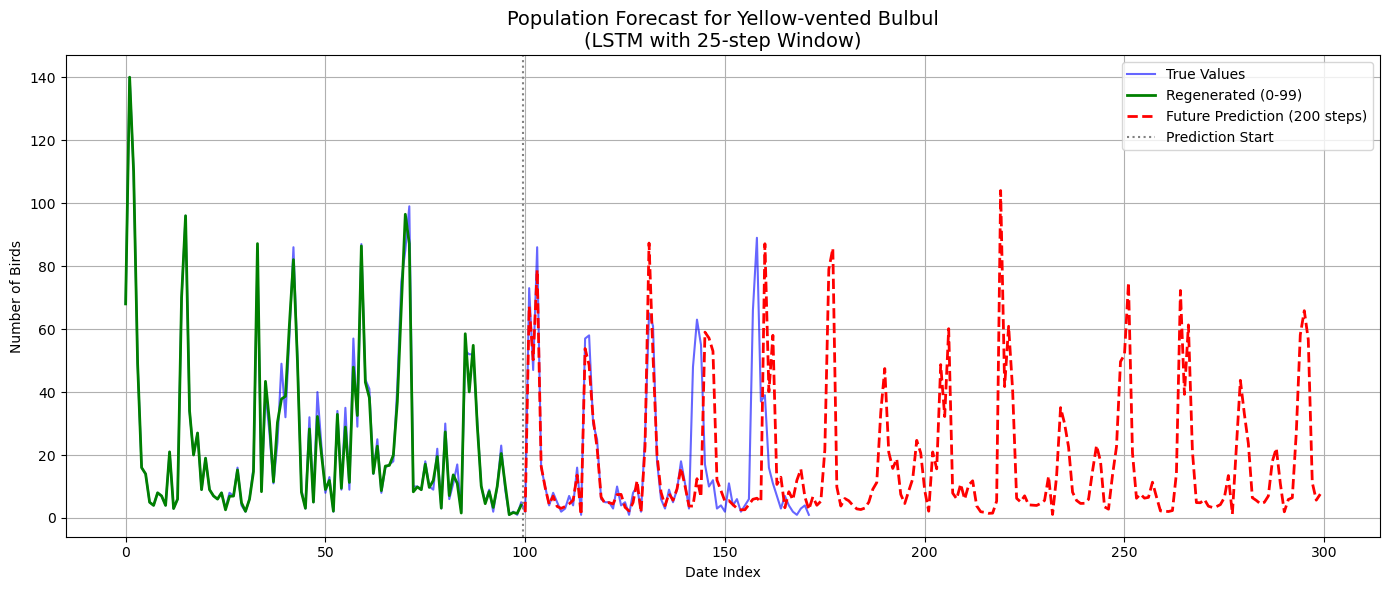

Model Performance Metrics of LSTM with 25-step Window:
MSE: 15.3988
RMSE: 3.9241
MAE: 2.5017


In [28]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

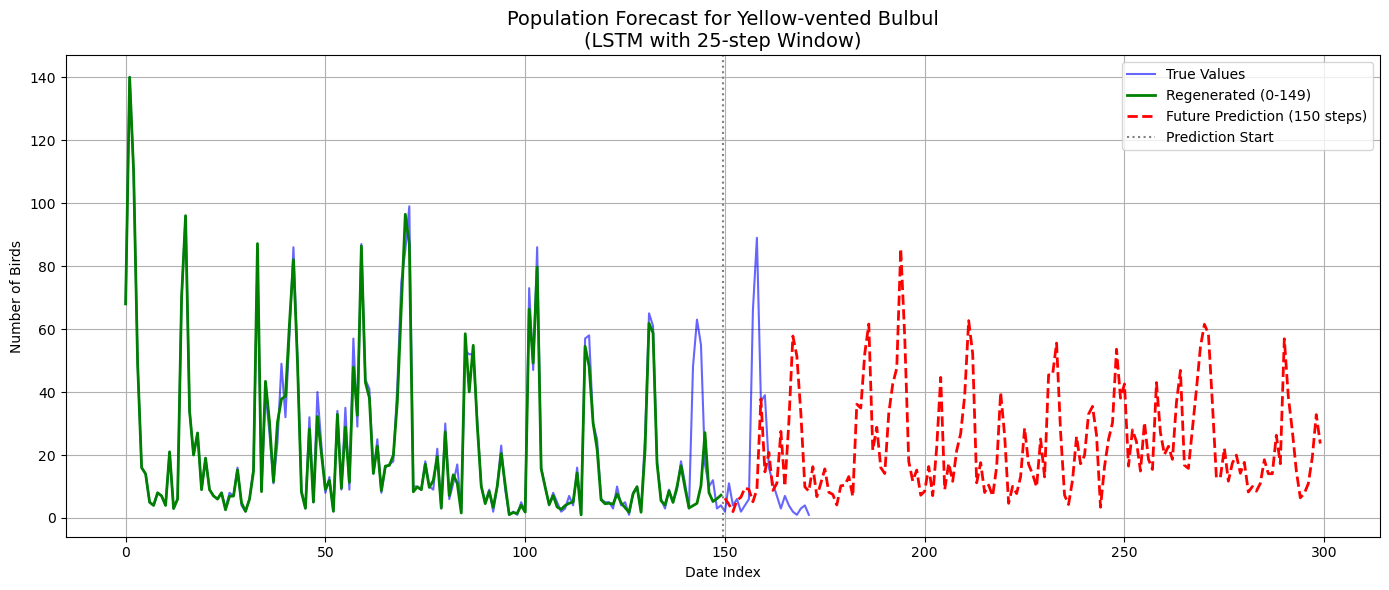

Model Performance Metrics of LSTM with 25-step Window:
MSE: 71.5603
RMSE: 8.4593
MAE: 3.4077


In [29]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


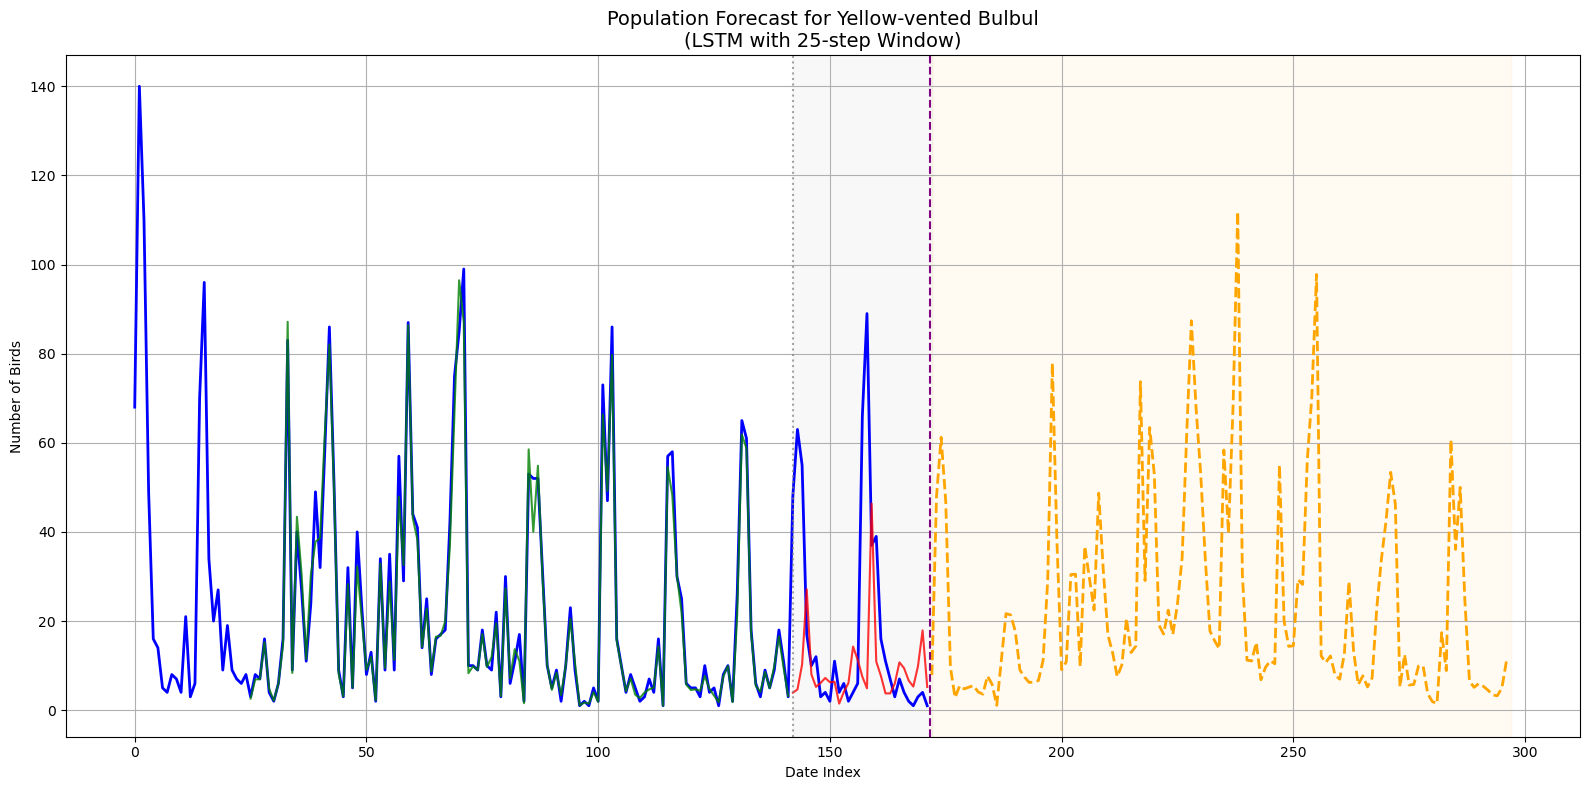


Model Performance Metrics of LSTM with 25-step Window:
Training RMSE: 3.49
Test RMSE: 25.54
Training MAE: 2.17
Test MAE: 15.00


In [30]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [31]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 7.91
Step 2: 47.91
Step 3: 61.24
Step 4: 46.69
Step 5: 9.69
Step 6: 2.81
Step 7: 5.46
Step 8: 4.78
Step 9: 5.17
Step 10: 5.51
Step 11: 4.07
Step 12: 3.60
Step 13: 7.67
Step 14: 5.80
Step 15: 1.09
Step 16: 11.29
Step 17: 21.66
Step 18: 21.38
Step 19: 17.72
Step 20: 9.02
Step 21: 7.42
Step 22: 6.23
Step 23: 6.29
Step 24: 6.67
Step 25: 11.18
Step 26: 29.23
Step 27: 77.90
Step 28: 37.44
Step 29: 9.08
Step 30: 10.84
Step 31: 30.44
Step 32: 30.51
Step 33: 9.84
Step 34: 36.78
Step 35: 29.57
Step 36: 22.47
Step 37: 48.70
Step 38: 31.21
Step 39: 16.82
Step 40: 12.90
Step 41: 7.53
Step 42: 10.18
Step 43: 20.58
Step 44: 12.93
Step 45: 14.37
Step 46: 73.70
Step 47: 29.08
Step 48: 63.42
Step 49: 52.89
Step 50: 19.09
Step 51: 17.10
Step 52: 22.44
Step 53: 16.99
Step 54: 23.91
Step 55: 34.14
Step 56: 62.27
Step 57: 87.39
Step 58: 67.89
Step 59: 53.15
Step 60: 33.95
Step 61: 17.79
Step 62: 15.60
Step 63: 13.81
Step 64: 58.38
Step 65: 39.70
Step 66: 68.54
Step 67

## **window size of 30**

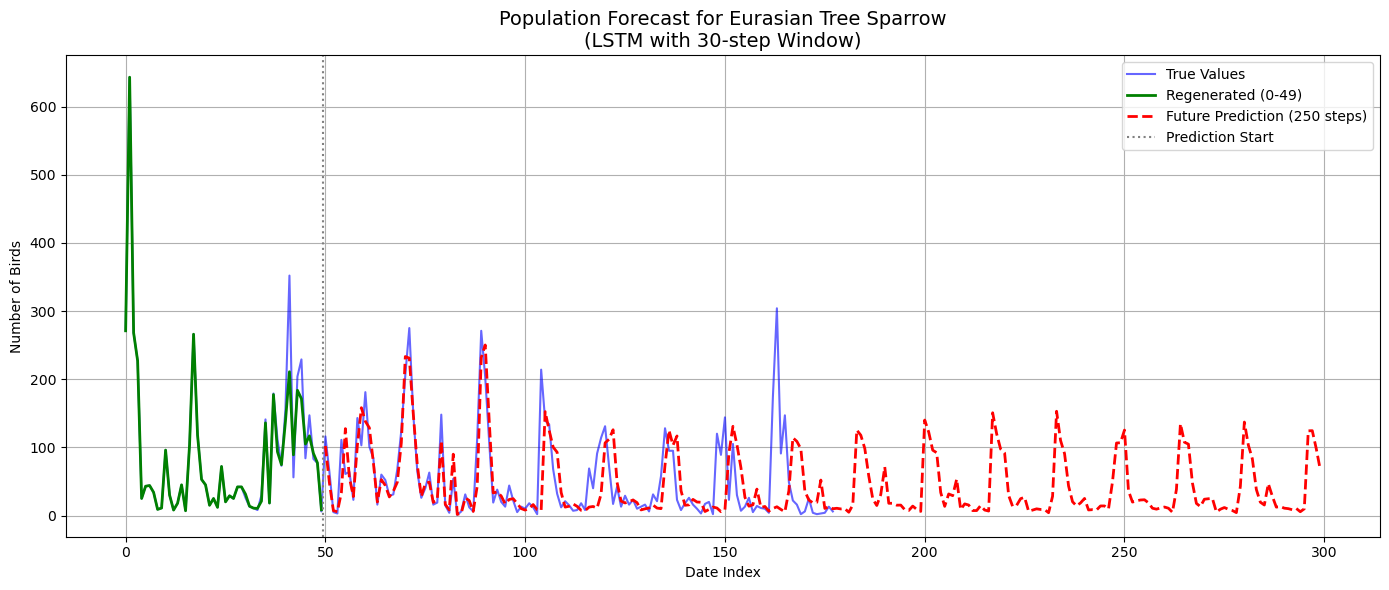

Model Performance Metrics of LSTM with 30-step Window:
MSE: 1347.2096
RMSE: 36.7044
MAE: 18.8063


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

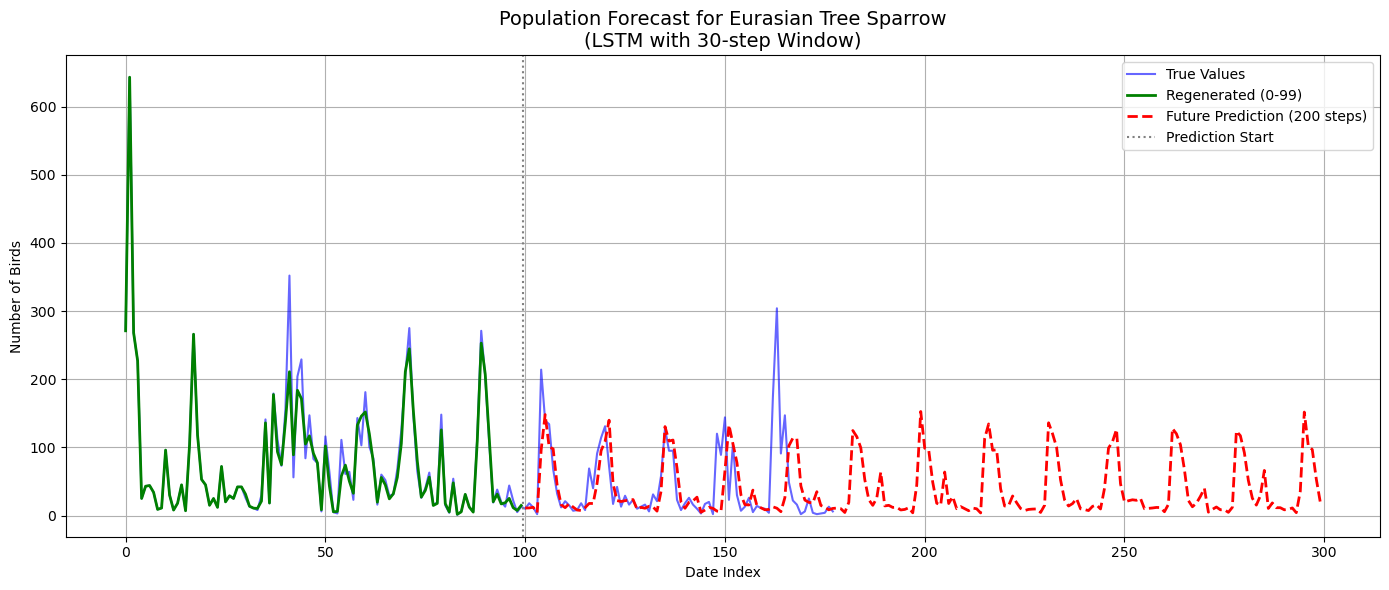

Model Performance Metrics of LSTM with 30-step Window:
MSE: 534.9111
RMSE: 23.1281
MAE: 12.1881


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

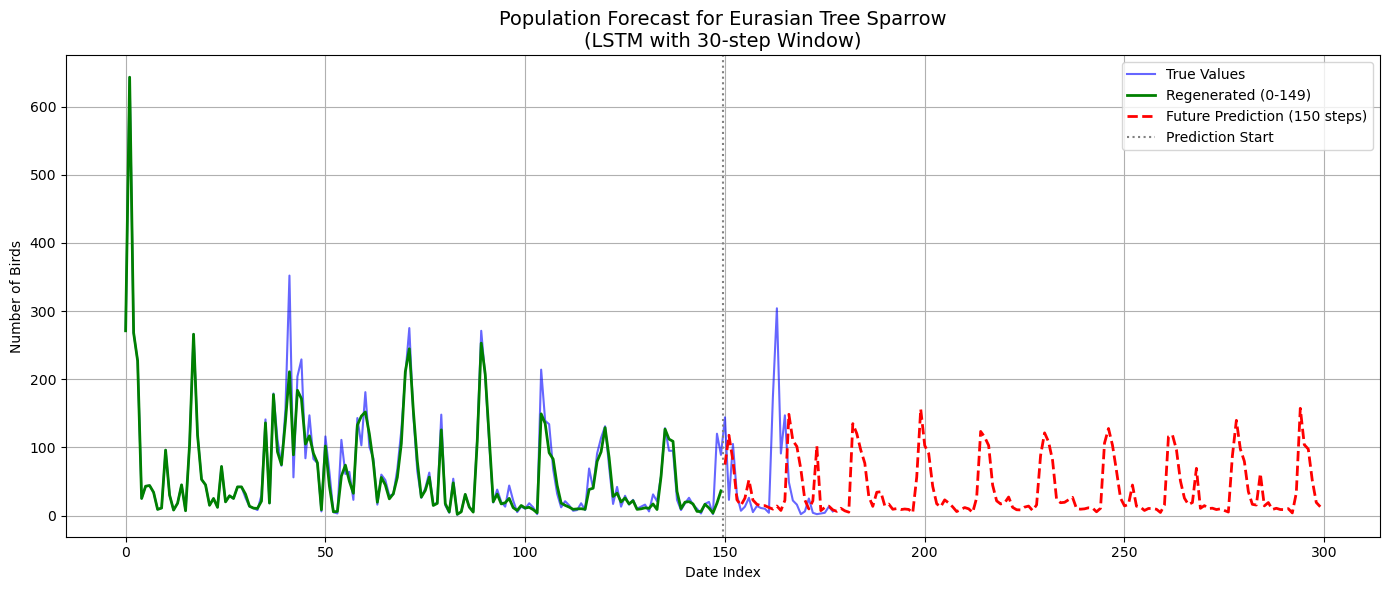

Model Performance Metrics of LSTM with 30-step Window:
MSE: 502.4858
RMSE: 22.4162
MAE: 11.7511


In [ ]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


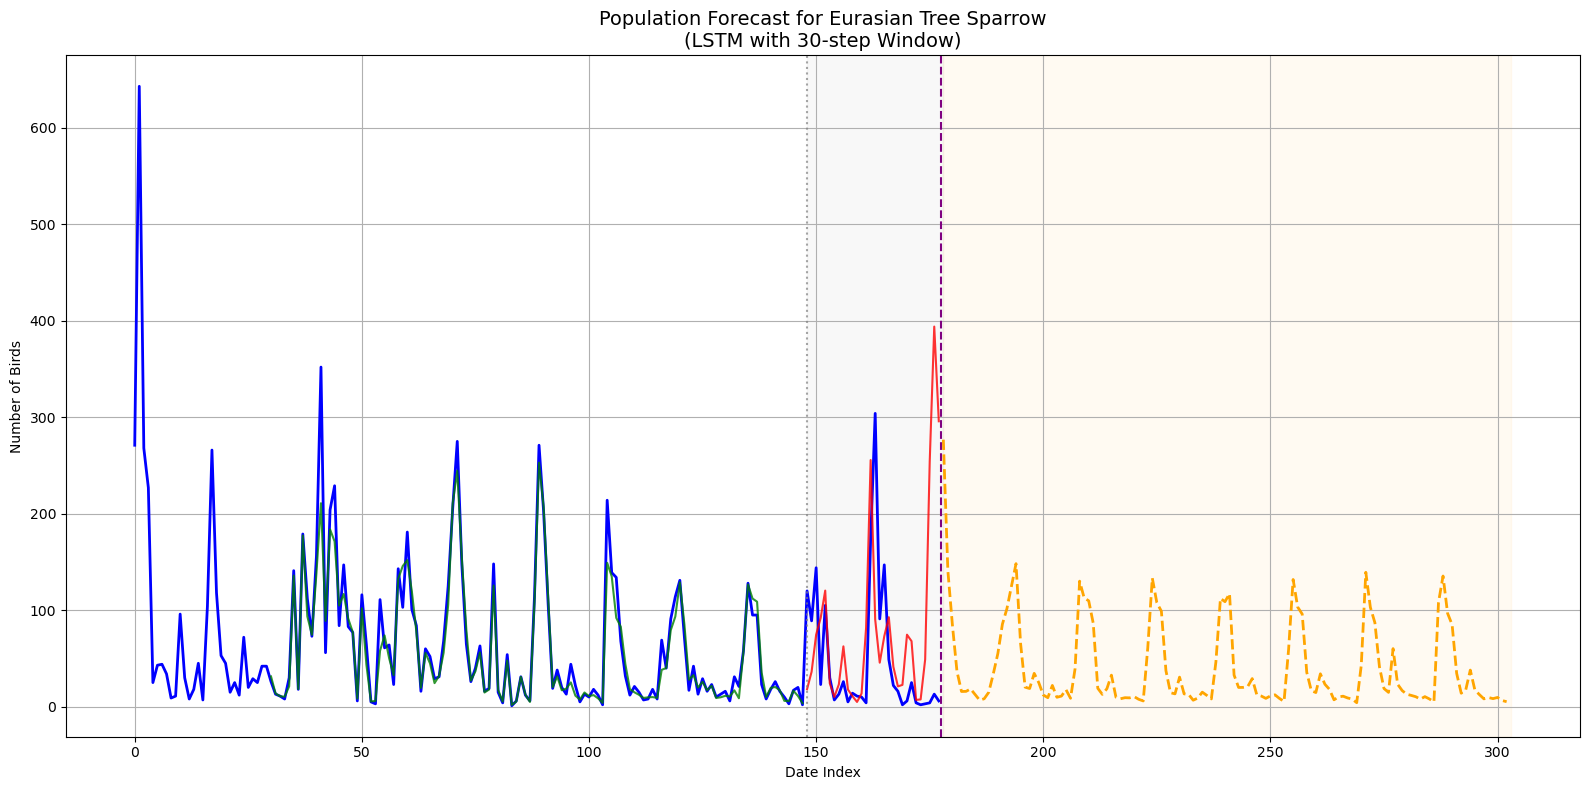


Model Performance Metrics of LSTM with {window_size}-step Window:
Training RMSE: 19.99
Test RMSE: 114.52
Training MAE: 10.64
Test MAE: 68.59


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [ ]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 276.75
Step 2: 140.77
Step 3: 84.56
Step 4: 36.70
Step 5: 15.78
Step 6: 15.90
Step 7: 18.46
Step 8: 12.59
Step 9: 6.75
Step 10: 8.27
Step 11: 15.00
Step 12: 34.11
Step 13: 55.08
Step 14: 85.50
Step 15: 101.66
Step 16: 124.98
Step 17: 148.27
Step 18: 65.70
Step 19: 20.27
Step 20: 18.84
Step 21: 34.59
Step 22: 25.07
Step 23: 12.16
Step 24: 9.36
Step 25: 22.08
Step 26: 9.78
Step 27: 11.02
Step 28: 17.66
Step 29: 8.76
Step 30: 39.39
Step 31: 130.13
Step 32: 112.73
Step 33: 109.78
Step 34: 86.50
Step 35: 19.10
Step 36: 12.79
Step 37: 18.62
Step 38: 32.71
Step 39: 9.90
Step 40: 8.27
Step 41: 9.35
Step 42: 9.17
Step 43: 10.47
Step 44: 7.69
Step 45: 5.99
Step 46: 60.92
Step 47: 133.30
Step 48: 107.79
Step 49: 98.97
Step 50: 37.42
Step 51: 14.50
Step 52: 13.32
Step 53: 30.66
Step 54: 13.30
Step 55: 12.77
Step 56: 6.73
Step 57: 8.96
Step 58: 15.10
Step 59: 11.72
Step 60: 8.06
Step 61: 46.45
Step 62: 112.24
Step 63: 108.86
Step 64: 117.18
Step 65: 32.82
Ste

## **Window Size of 50**

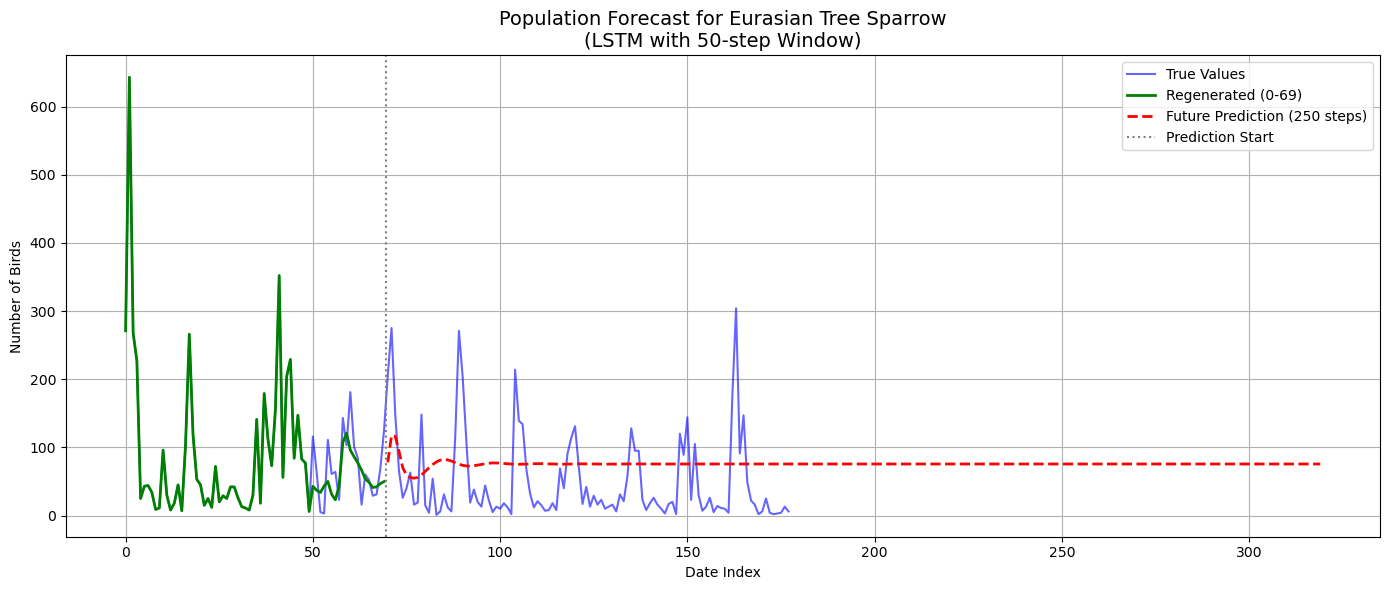

Model Performance Metrics of LSTM with 50-step Window:
MSE: 1663.2449
RMSE: 40.7829
MAE: 33.0275


In [ ]:
regenerate_points = 70
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

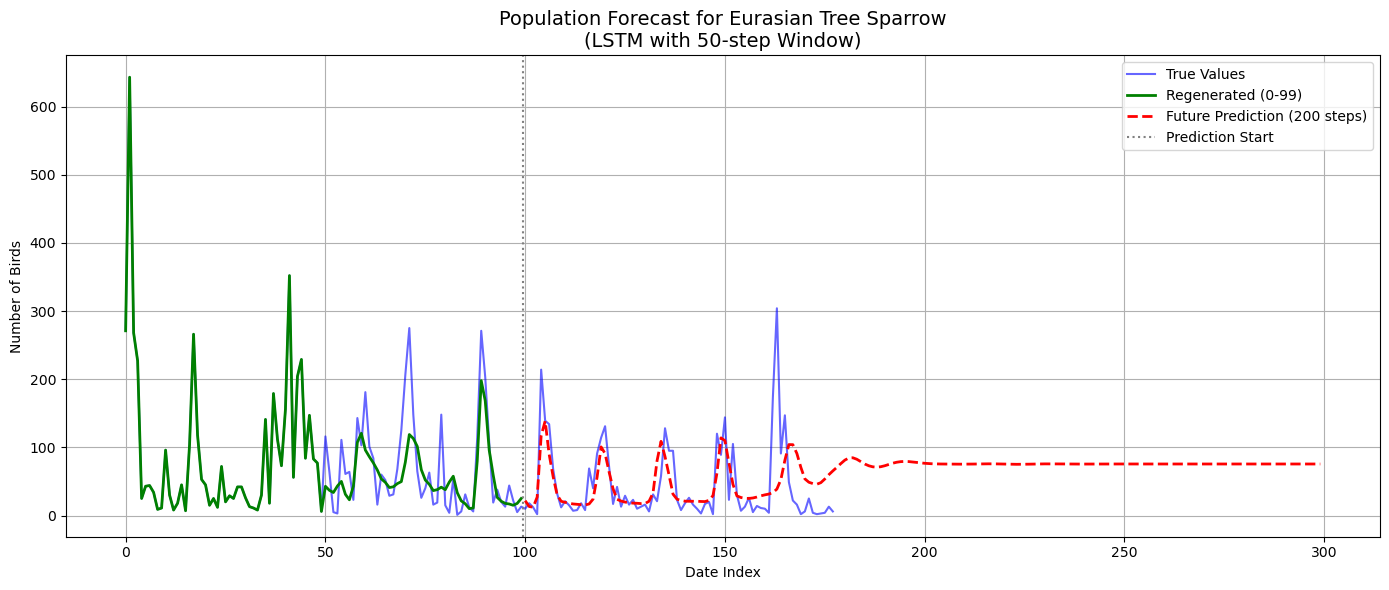

Model Performance Metrics of LSTM with 50-step Window:
MSE: 2111.4312
RMSE: 45.9503
MAE: 32.8332


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

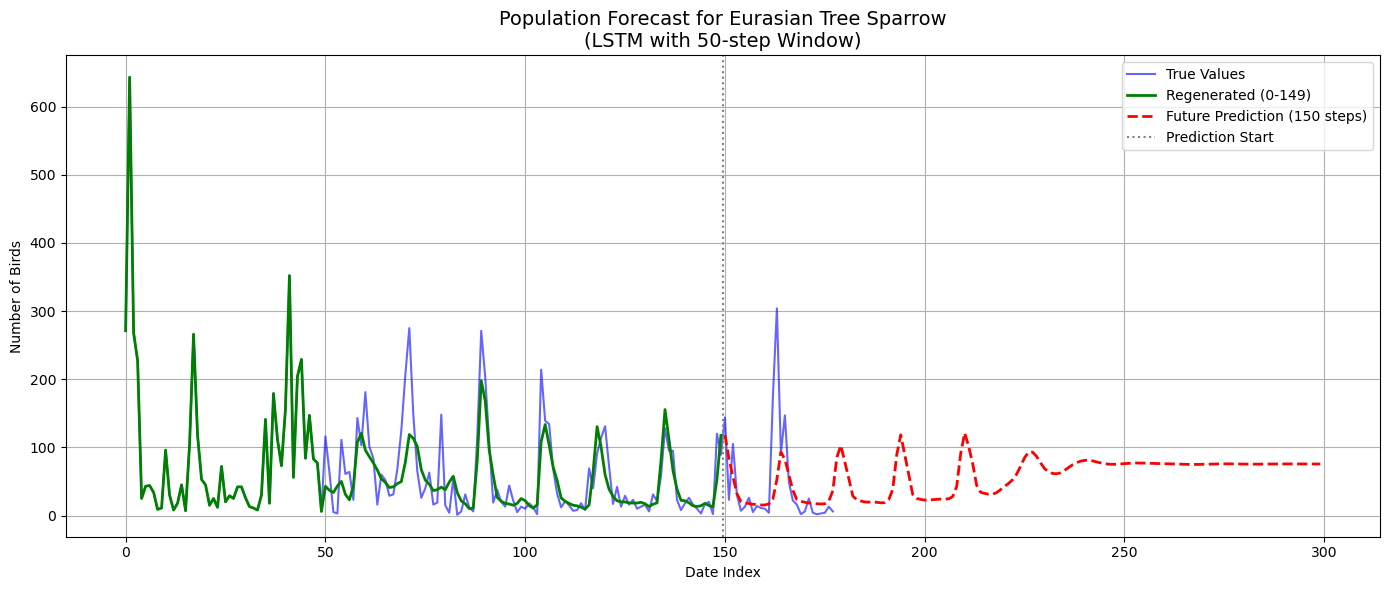

Model Performance Metrics of LSTM with 50-step Window:
MSE: 1397.0236
RMSE: 37.3768
MAE: 24.6983


In [ ]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


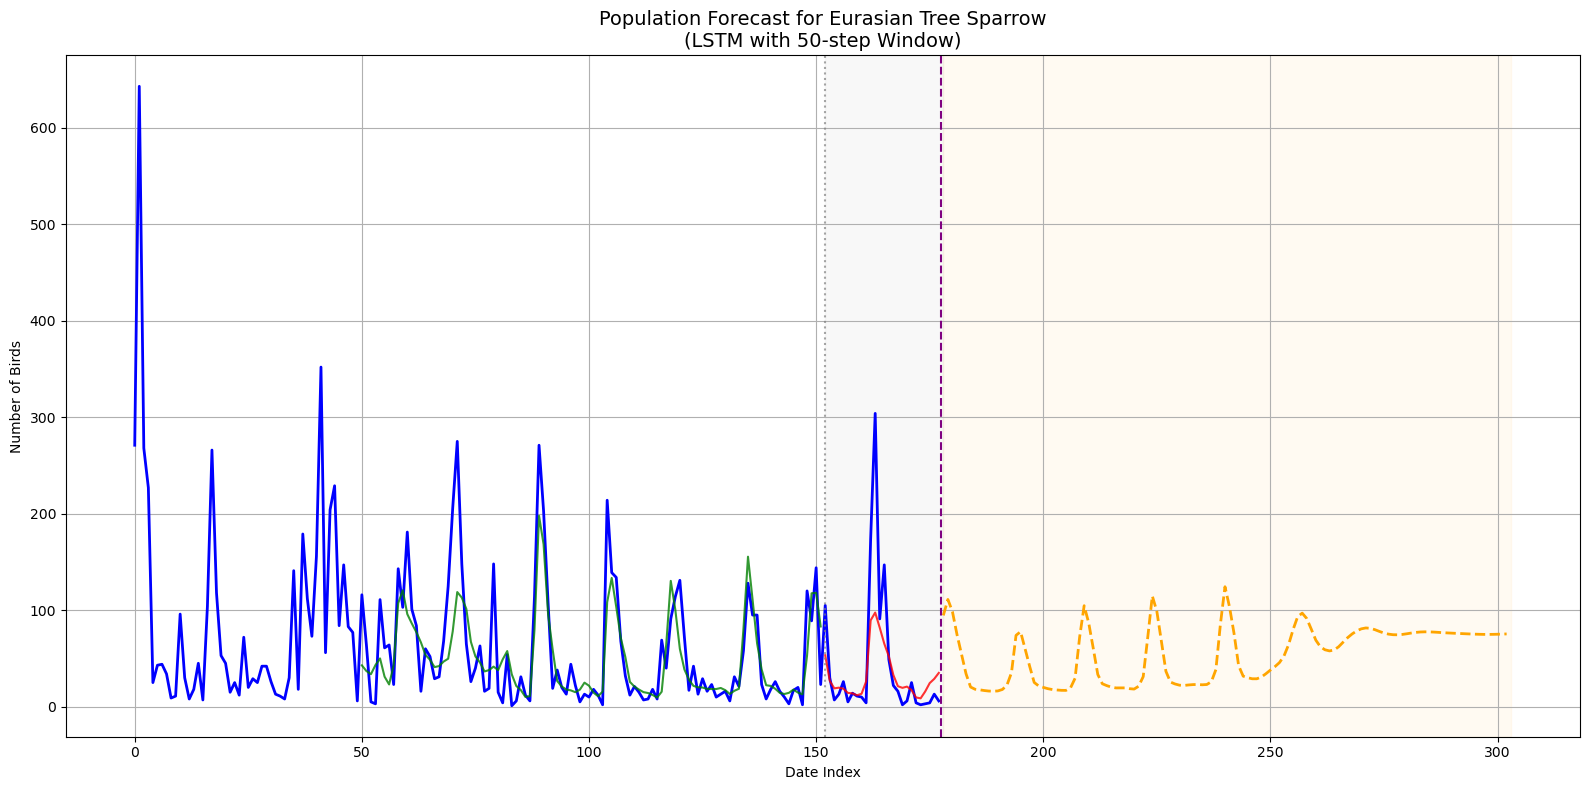


Model Performance Metrics of LSTM with {window_size}-step Window:
Training RMSE: 37.57
Test RMSE: 49.03
Training MAE: 25.06
Test MAE: 24.94


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [ ]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 94.63
Step 2: 111.15
Step 3: 98.62
Step 4: 74.95
Step 5: 54.46
Step 6: 34.06
Step 7: 20.39
Step 8: 18.07
Step 9: 17.51
Step 10: 16.78
Step 11: 16.24
Step 12: 16.08
Step 13: 16.36
Step 14: 17.87
Step 15: 22.34
Step 16: 35.22
Step 17: 73.95
Step 18: 77.76
Step 19: 59.93
Step 20: 41.95
Step 21: 25.17
Step 22: 21.48
Step 23: 20.05
Step 24: 18.70
Step 25: 17.79
Step 26: 17.34
Step 27: 16.98
Step 28: 16.92
Step 29: 19.54
Step 30: 29.48
Step 31: 72.00
Step 32: 104.70
Step 33: 86.85
Step 34: 60.58
Step 35: 33.44
Step 36: 23.79
Step 37: 21.81
Step 38: 20.27
Step 39: 19.47
Step 40: 19.51
Step 41: 19.51
Step 42: 18.68
Step 43: 18.28
Step 44: 21.27
Step 45: 31.20
Step 46: 72.07
Step 47: 114.77
Step 48: 98.92
Step 49: 67.80
Step 50: 36.65
Step 51: 25.54
Step 52: 23.56
Step 53: 22.30
Step 54: 22.06
Step 55: 22.56
Step 56: 22.94
Step 57: 23.01
Step 58: 22.74
Step 59: 23.01
Step 60: 25.88
Step 61: 38.48
Step 62: 85.83
Step 63: 124.35
Step 64: 103.37
Step 65: 75.

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

**average bird perdiction**

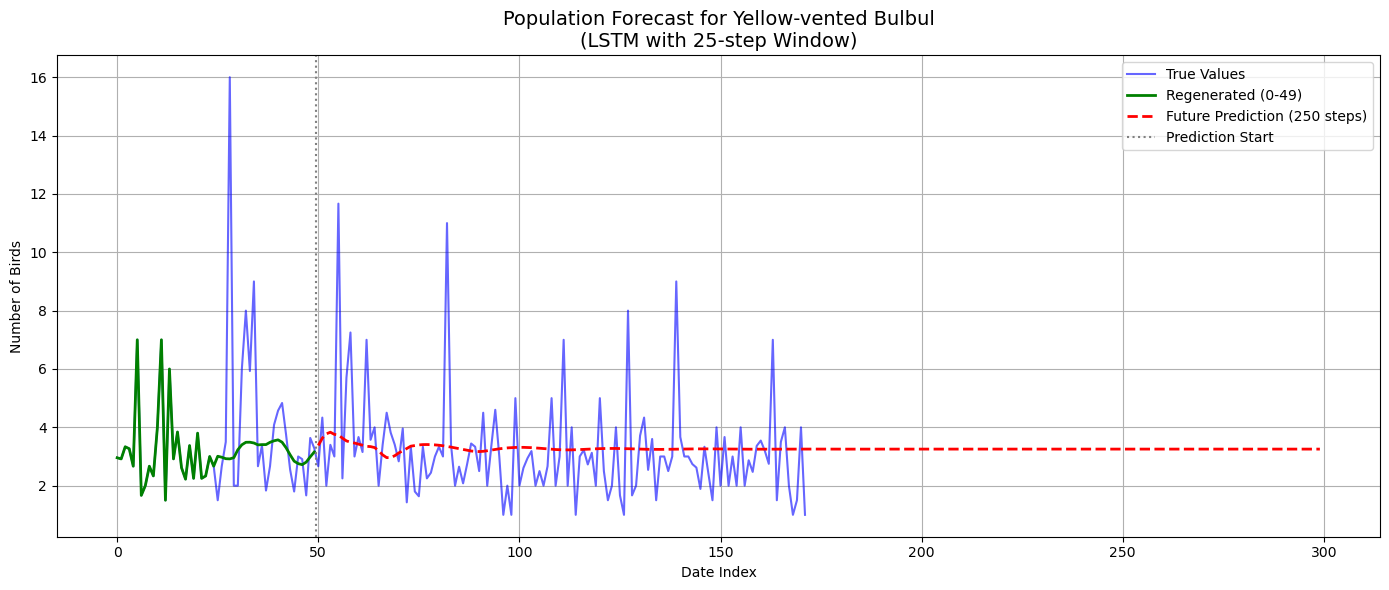

Model Performance Metrics of LSTM with 25-step Window:
MSE: 10.0071
RMSE: 3.1634
MAE: 1.7258


In [19]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(avg_values_log[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = avg_values_log[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = avg_values_log[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(avg_values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {second_most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = avg_values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

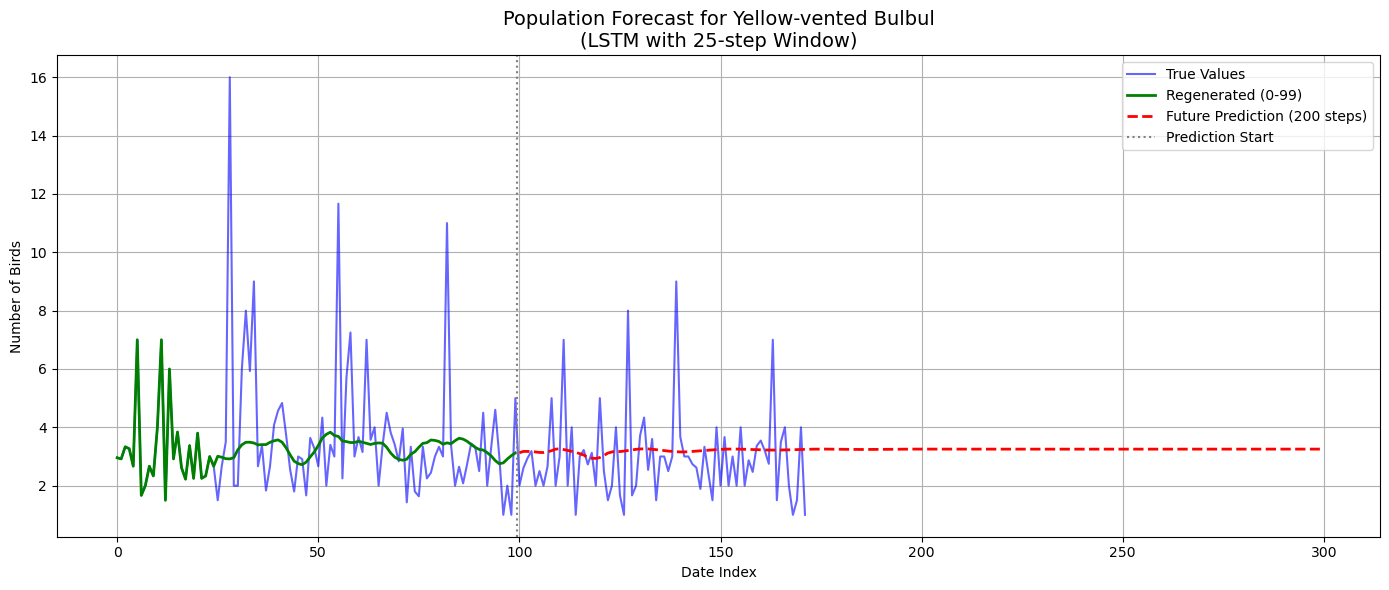

Model Performance Metrics of LSTM with 25-step Window:
MSE: 5.9936
RMSE: 2.4482
MAE: 1.4106


In [20]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(avg_values_log[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = avg_values_log[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = avg_values_log[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(avg_values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {second_most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = avg_values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

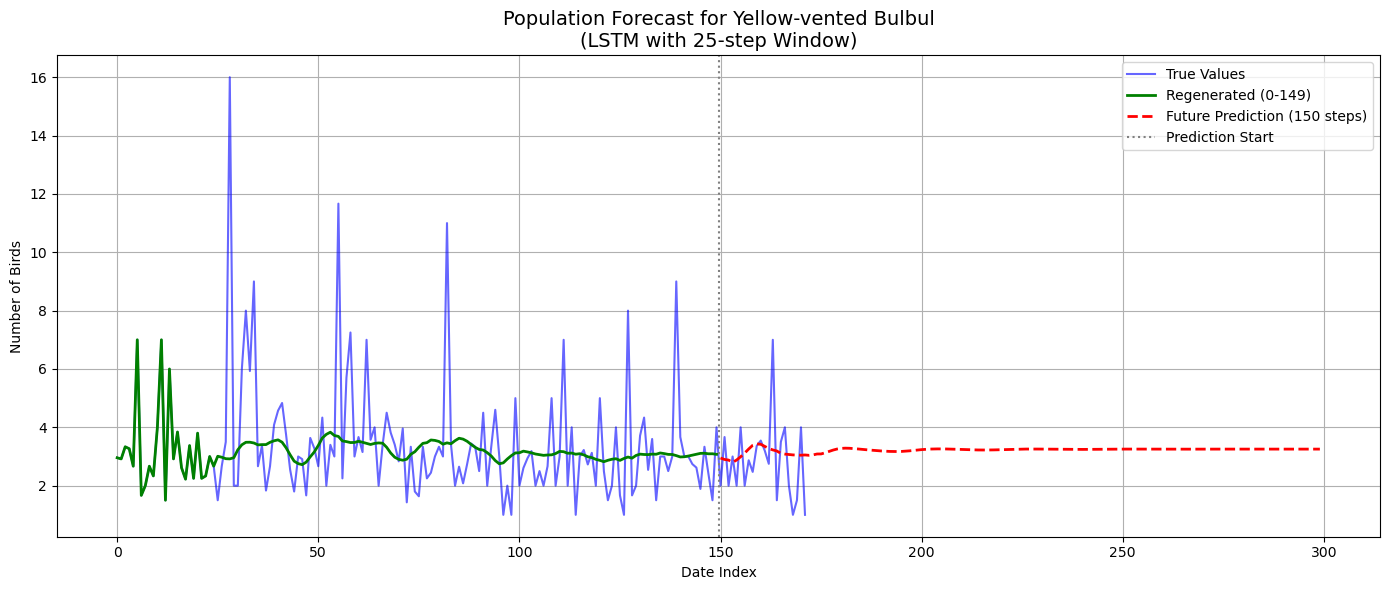

Model Performance Metrics of LSTM with 25-step Window:
MSE: 4.5575
RMSE: 2.1348
MAE: 1.2584


In [21]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(avg_values_log[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = avg_values_log[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = avg_values_log[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(avg_values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {second_most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = avg_values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


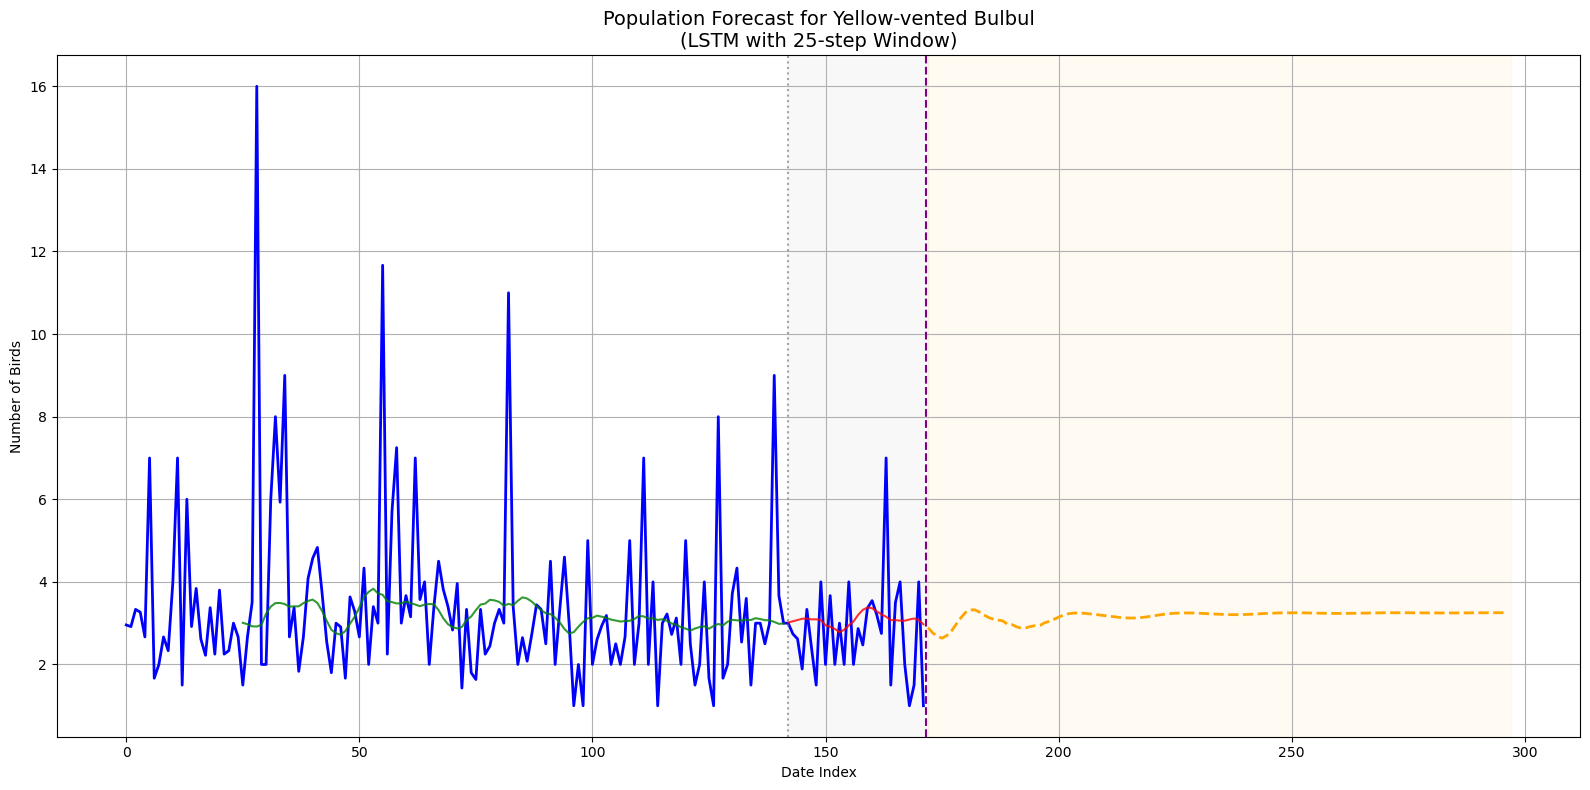


Model Performance Metrics of LSTM with 25-step Window:
Training RMSE: 2.20
Test RMSE: 1.20
Training MAE: 1.30
Test MAE: 0.92


In [22]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = avg_values_log[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(avg_values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(avg_values)), avg_values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(avg_values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(avg_values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(avg_values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {second_most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [23]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 2.89
Step 2: 2.76
Step 3: 2.69
Step 4: 2.64
Step 5: 2.70
Step 6: 2.81
Step 7: 2.97
Step 8: 3.12
Step 9: 3.26
Step 10: 3.32
Step 11: 3.32
Step 12: 3.27
Step 13: 3.20
Step 14: 3.14
Step 15: 3.10
Step 16: 3.08
Step 17: 3.06
Step 18: 2.98
Step 19: 2.97
Step 20: 2.91
Step 21: 2.88
Step 22: 2.89
Step 23: 2.92
Step 24: 2.94
Step 25: 2.95
Step 26: 3.01
Step 27: 3.04
Step 28: 3.09
Step 29: 3.15
Step 30: 3.19
Step 31: 3.22
Step 32: 3.24
Step 33: 3.25
Step 34: 3.24
Step 35: 3.23
Step 36: 3.22
Step 37: 3.21
Step 38: 3.19
Step 39: 3.18
Step 40: 3.17
Step 41: 3.15
Step 42: 3.14
Step 43: 3.13
Step 44: 3.12
Step 45: 3.12
Step 46: 3.13
Step 47: 3.14
Step 48: 3.15
Step 49: 3.17
Step 50: 3.19
Step 51: 3.21
Step 52: 3.22
Step 53: 3.23
Step 54: 3.24
Step 55: 3.25
Step 56: 3.25
Step 57: 3.25
Step 58: 3.24
Step 59: 3.24
Step 60: 3.24
Step 61: 3.23
Step 62: 3.22
Step 63: 3.22
Step 64: 3.21
Step 65: 3.21
Step 66: 3.21
Step 67: 3.21
Step 68: 3.21
Step 69: 3.21
Step 70: 3.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess
avg_df = pd.read_csv("participants_data2.csv")
avg_df.columns = avg_df.columns.str.strip()
avg_df['Date Created'] = pd.to_datetime(avg_df['Date Created'], format='mixed', dayfirst=True, errors='coerce')

bird_counts = avg_df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[0]
filtered_df = avg_df[avg_df['Bird Name'] == most_frequent_bird]

participants_per_day = filtered_df.groupby('Date Created')['Participant Name'].nunique()
total_birds_per_day = filtered_df.groupby('Date Created')['Number of Birds'].sum()
average_birds_per_participant = total_birds_per_day / participants_per_day

values_avg = average_birds_per_participant.values.astype('float32').reshape(-1, 1)
scaler_avg = MinMaxScaler()
values_scaled_avg = scaler_avg.fit_transform(values_avg)

In [ ]:
# Parameters
window_size = 60
regenerate_points = 150
future_steps = 150

# Create dataset
def create_dataset(data, window_size, forecast_steps=1):
    X, Y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size])
        Y.append(data[i + window_size:i + window_size + forecast_steps])
    return np.array(X), np.array(Y)

# Train and predict
def train_and_predict(model, model_name, values_scaled, window_size, regenerate_points, future_steps):
    X, Y = create_dataset(values_scaled, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    model.fit(X_train, Y_train, epochs=500, verbose=0, validation_data=(X_test, Y_test))

    regen_pred_actual = []
    for i in range(window_size):
        regen_pred_actual.append(values_scaled[i][0])
    for i in range(regenerate_points - window_size):
        input_window = values_scaled[i:i + window_size].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        regen_pred_actual.append(pred)

    future_input = values_scaled[regenerate_points - window_size:regenerate_points]
    future_predictions = []
    for _ in range(future_steps):
        input_window = future_input[-window_size:].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input[1:], pred)

    regen_pred_actual = scaler_avg.inverse_transform(np.array(regen_pred_actual).reshape(-1, 1))
    future_actual = scaler_avg.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    regen_pred_actual[regen_pred_actual < 0] = 0
    future_actual[future_actual < 0] = 0

    true_values = values_avg[window_size:regenerate_points]
    predicted_values = regen_pred_actual[window_size:regenerate_points]
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = mean_absolute_percentage_error(true_values, predicted_values) * 100

    print(f"\nModel: {model_name}")
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    return regen_pred_actual, future_actual

In [ ]:
# Model A - Shallow
model_a = Sequential()
model_a.add(LSTM(64, return_sequences=True, input_shape=(window_size, 1)))
model_a.add(LSTM(32))
model_a.add(Dense(1))

# Model B - Medium
model_b = Sequential()
model_b.add(LSTM(128, return_sequences=True, input_shape=(window_size, 1)))
model_b.add(Dropout(0.2))
model_b.add(LSTM(64, return_sequences=True))
model_b.add(Dropout(0.2))
model_b.add(LSTM(32))
model_b.add(Dropout(0.2))
model_b.add(Dense(1))

# Model C - Deep
model_c = Sequential()
model_c.add(LSTM(512, return_sequences=True, input_shape=(window_size, 1)))
model_c.add(Dropout(0.2))
model_c.add(LSTM(256, return_sequences=True))
model_c.add(Dropout(0.2))
model_c.add(LSTM(128, return_sequences=True))
model_c.add(Dropout(0.2))
model_c.add(LSTM(64, return_sequences=True))
model_c.add(Dropout(0.2))
model_c.add(LSTM(32))
model_c.add(Dropout(0.2))
model_c.add(Dense(1))

# Model D - Two LSTM layers only
model_d = Sequential()
model_d.add(LSTM(128, return_sequences=True, input_shape=(window_size, 1)))
model_d.add(LSTM(64))
model_d.add(Dense(1))

model_a.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_b.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_c.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_d.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train and collect predictions
regen_a, future_a = train_and_predict(model_a, "Shallow", values_scaled_avg, window_size, regenerate_points, future_steps)
regen_b, future_b = train_and_predict(model_b, "Medium", values_scaled_avg, window_size, regenerate_points, future_steps)
regen_c, future_c = train_and_predict(model_c, "Deep", values_scaled_avg, window_size, regenerate_points, future_steps)
regen_d, future_d = train_and_predict(model_d, "Two-Layer", values_scaled_avg, window_size, regenerate_points, future_steps)


Model: Shallow
MSE: 8.0955, RMSE: 2.8453, MAE: 2.2209, MAPE: 40.28%

Model: Medium
MSE: 15.7503, RMSE: 3.9687, MAE: 2.8356, MAPE: 52.24%

Model: Deep
MSE: 14.6027, RMSE: 3.8214, MAE: 2.7731, MAPE: 51.00%

Model: Two-Layer
MSE: 7.0613, RMSE: 2.6573, MAE: 2.0755, MAPE: 40.11%


In [ ]:
# Train on total bird counts
file_path = "birds_observation_data_with_index.csv"
df_total = pd.read_csv(file_path)
df_total['Date Index'] = pd.to_numeric(df_total['Date Index'], errors='coerce')

bird_data_total = df_total[df_total['Bird Name'] == most_frequent_bird]
bird_trend_total = bird_data_total.groupby('Date Index')['Number of Birds'].sum().sort_index()
values_total = bird_trend_total.values.astype('float32').reshape(-1, 1)

values_total_log = np.log1p(values_total)

X_total, Y_total = create_dataset(values_total_log, window_size)
X_total = X_total.reshape((X_total.shape[0], X_total.shape[1], 1))

split_total = int(len(X_total) * 0.8)
X_train_total, X_test_total = X_total[:split_total], X_total[split_total:]
Y_train_total, Y_test_total = Y_total[:split_total], Y_total[split_total:]

model_total = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])
model_total.compile(optimizer='adam', loss='mse')

print("\nTraining on total bird count data...")
model_total.fit(X_train_total, Y_train_total, epochs=500, verbose=0, validation_data=(X_test_total, Y_test_total))


# Use average birds per participant (scaled) as input for prediction
regen_avg_from_total_model = []
for i in range(window_size):
    regen_avg_from_total_model.append(values_scaled_avg[i][0])

# Predict next points one by one using model trained on total count
for i in range(len(values_scaled_avg) - window_size):
    input_window = np.array(regen_avg_from_total_model[-window_size:]).reshape(1, window_size, 1)
    pred = model_total.predict(input_window, verbose=0)[0, 0]
    regen_avg_from_total_model.append(pred)

# Inverse transform predictions
regen_avg_from_total_model = scaler_avg.inverse_transform(
    np.array(regen_avg_from_total_model).reshape(-1, 1)
)
regen_avg_from_total_model[regen_avg_from_total_model < 0] = 0

# Evaluate the regenerated predictions
y_true_avg = values_avg[window_size:]
y_pred_avg = regen_avg_from_total_model[window_size:]

mse_avg = mean_squared_error(y_true_avg, y_pred_avg)
rmse_avg = np.sqrt(mse_avg)
mae_avg = mean_absolute_error(y_true_avg, y_pred_avg)
mape_avg = mean_absolute_percentage_error(y_true_avg, y_pred_avg) * 100

print("\nMetrics: Total-Trained Model Applied to Avg Birds per Participant Input")
print(f"MSE: {mse_avg:.4f}")
print(f"RMSE: {rmse_avg:.4f}")
print(f"MAE: {mae_avg:.4f}")
print(f"MAPE: {mape_avg:.2f}%")


Training on total bird count data...

Metrics: Total-Trained Model Applied to Avg Birds per Participant Input
MSE: 10378.5850
RMSE: 101.8753
MAE: 97.0583
MAPE: 1833.02%


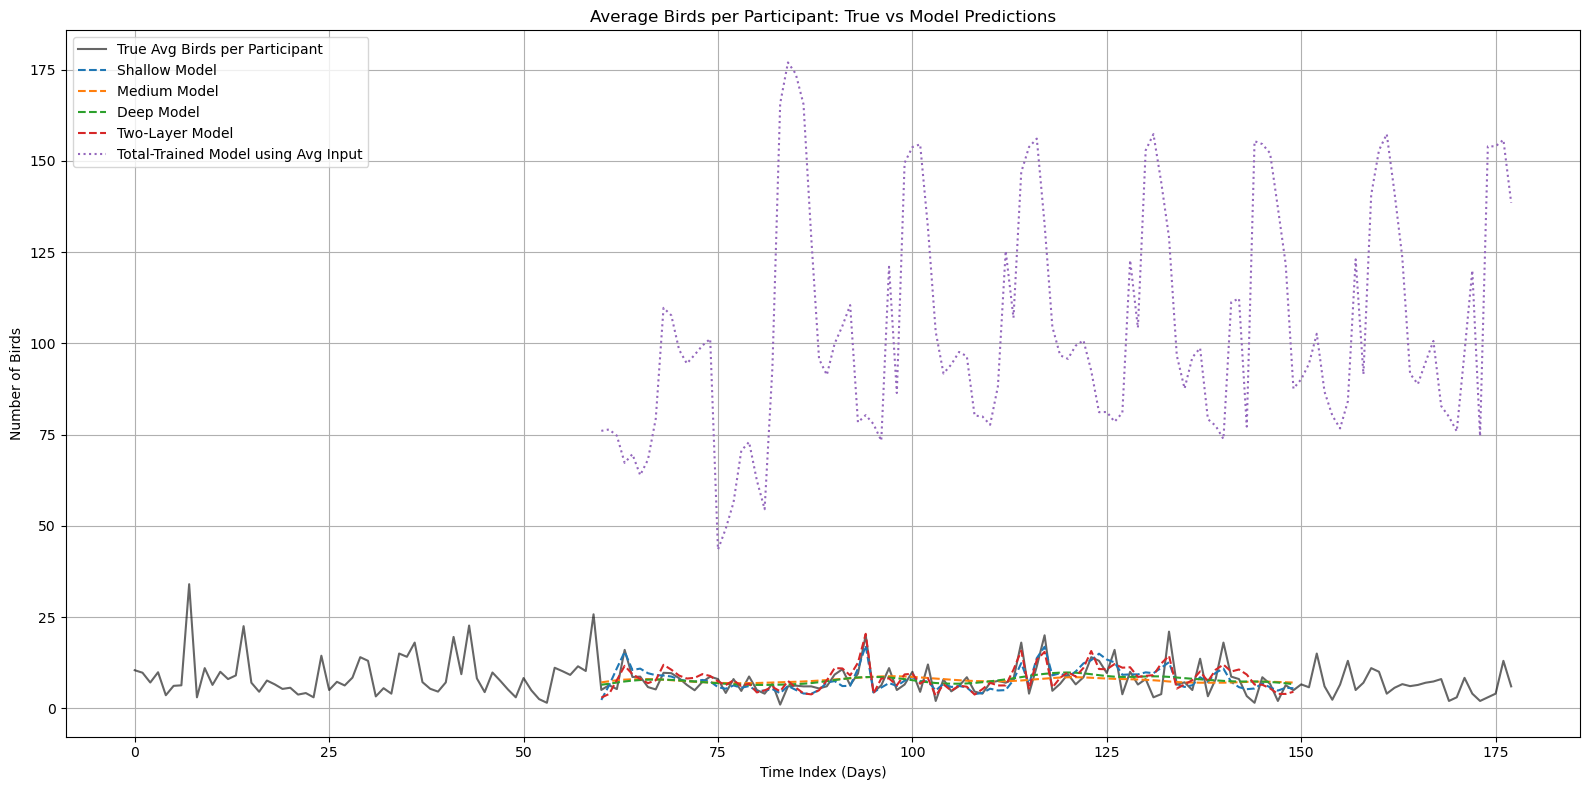

In [ ]:
plt.figure(figsize=(16, 8))

# True average birds per participant
plt.plot(values_avg, label='True Avg Birds per Participant', color='black', alpha=0.6)

# Regenerated predictions from average-trained models
plt.plot(range(window_size, len(regen_a)), regen_a[window_size:], label='Shallow Model', linestyle='--')
plt.plot(range(window_size, len(regen_b)), regen_b[window_size:], label='Medium Model', linestyle='--')
plt.plot(range(window_size, len(regen_c)), regen_c[window_size:], label='Deep Model', linestyle='--')
plt.plot(range(window_size, len(regen_d)), regen_d[window_size:], label='Two-Layer Model', linestyle='--')

# Regenerated prediction using model trained on total count
plt.plot(range(window_size, len(regen_avg_from_total_model)), regen_avg_from_total_model[window_size:], label='Total-Trained Model using Avg Input', linestyle=':')

plt.title('Average Birds per Participant: True vs Model Predictions')
plt.xlabel('Time Index (Days)')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**add two layer**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')
import os
import random
import tensorflow as tf

# For reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


avg_df = pd.read_csv("participants_data2.csv")
avg_df.columns = avg_df.columns.str.strip()
avg_df['Date Created'] = pd.to_datetime(avg_df['Date Created'], format='mixed', dayfirst=True, errors='coerce')

bird_counts = avg_df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[0]
print(f"Most frequently seen bird: {most_frequent_bird}")

filtered_df = avg_df[avg_df['Bird Name'] == most_frequent_bird]
participants_per_day = filtered_df.groupby('Date Created')['Participant Name'].nunique()
total_birds_per_day = filtered_df.groupby('Date Created')['Number of Birds'].sum()
average_birds_per_participant = total_birds_per_day / participants_per_day

values = average_birds_per_participant.values.astype('float32').reshape(-1, 1)
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

Most frequently seen bird: Eurasian Tree Sparrow


In [ ]:
# Dataset creation
def create_dataset(data, window_size, forecast_steps=1):
    X, Y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size])
        Y.append(data[i + window_size:i + window_size + forecast_steps])
    return np.array(X), np.array(Y)

# Train and predict function
def train_and_predict(model, model_name, values_scaled, window_size, regenerate_points, future_steps):
    X, Y = create_dataset(values_scaled, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=500, verbose=0, validation_data=(X_test, Y_test), shuffle=False)

    # Regeneration
    regen_pred_actual = []
    for i in range(window_size):
        regen_pred_actual.append(values_scaled[i][0])
    for i in range(regenerate_points - window_size):
        input_window = values_scaled[i:i + window_size].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        regen_pred_actual.append(pred)

    # Future prediction
    future_input = values_scaled[regenerate_points - window_size:regenerate_points]
    future_predictions = []
    for _ in range(future_steps):
        input_window = future_input[-window_size:].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input[1:], pred)

    # Inverse transform
    regen_pred_actual = scaler.inverse_transform(np.array(regen_pred_actual).reshape(-1, 1))
    future_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    regen_pred_actual[regen_pred_actual < 0] = 0
    future_actual[future_actual < 0] = 0

    # Metrics
    true_values = values[window_size:regenerate_points]
    predicted_values = regen_pred_actual[window_size:regenerate_points]
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = mean_absolute_percentage_error(true_values, predicted_values) * 100

    print(f"\n Model: {model_name}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return regen_pred_actual, future_actual

In [ ]:
# Parameters
window_size = 60
regenerate_points = 150
future_steps = 150

# Model A - Shallow
model_a = Sequential()
model_a.add(LSTM(64, return_sequences=True, input_shape=(window_size, 1)))
model_a.add(LSTM(32))
model_a.add(Dense(1))

# Model B - Medium
model_b = Sequential()
model_b.add(LSTM(128, return_sequences=True, input_shape=(window_size, 1)))
model_b.add(Dropout(0.2))
model_b.add(LSTM(64, return_sequences=True))
model_b.add(Dropout(0.2))
model_b.add(LSTM(32))
model_b.add(Dropout(0.2))
model_b.add(Dense(1))

# Model C - Deep
model_c = Sequential()
model_c.add(LSTM(512, return_sequences=True, input_shape=(window_size, 1)))
model_c.add(Dropout(0.2))
model_c.add(LSTM(256, return_sequences=True))
model_c.add(Dropout(0.2))
model_c.add(LSTM(128, return_sequences=True))
model_c.add(Dropout(0.2))
model_c.add(LSTM(64, return_sequences=True))
model_c.add(Dropout(0.2))
model_c.add(LSTM(32))
model_c.add(Dropout(0.2))
model_c.add(Dense(1))

# Model D - Two LSTM layers only
model_d = Sequential()
model_d.add(LSTM(128, return_sequences=True, input_shape=(window_size, 1)))
model_d.add(LSTM(64))
model_d.add(Dense(1))

# Train and collect predictions
regen_a, future_a = train_and_predict(model_a, "Shallow", values_scaled, window_size, regenerate_points, future_steps)
regen_b, future_b = train_and_predict(model_b, "Medium", values_scaled, window_size, regenerate_points, future_steps)
regen_c, future_c = train_and_predict(model_c, "Deep", values_scaled, window_size, regenerate_points, future_steps)
regen_d, future_d = train_and_predict(model_d, "Two-Layer", values_scaled, window_size, regenerate_points, future_steps)


 Model: Shallow
MSE: 10.4863
RMSE: 3.2383
MAE: 2.3925
MAPE: 41.49%

 Model: Medium
MSE: 14.4094
RMSE: 3.7960
MAE: 2.7079
MAPE: 47.96%

 Model: Deep
MSE: 15.7089
RMSE: 3.9634
MAE: 2.9114
MAPE: 55.99%

 Model: Two-Layer
MSE: 9.5081
RMSE: 3.0835
MAE: 2.2963
MAPE: 36.60%


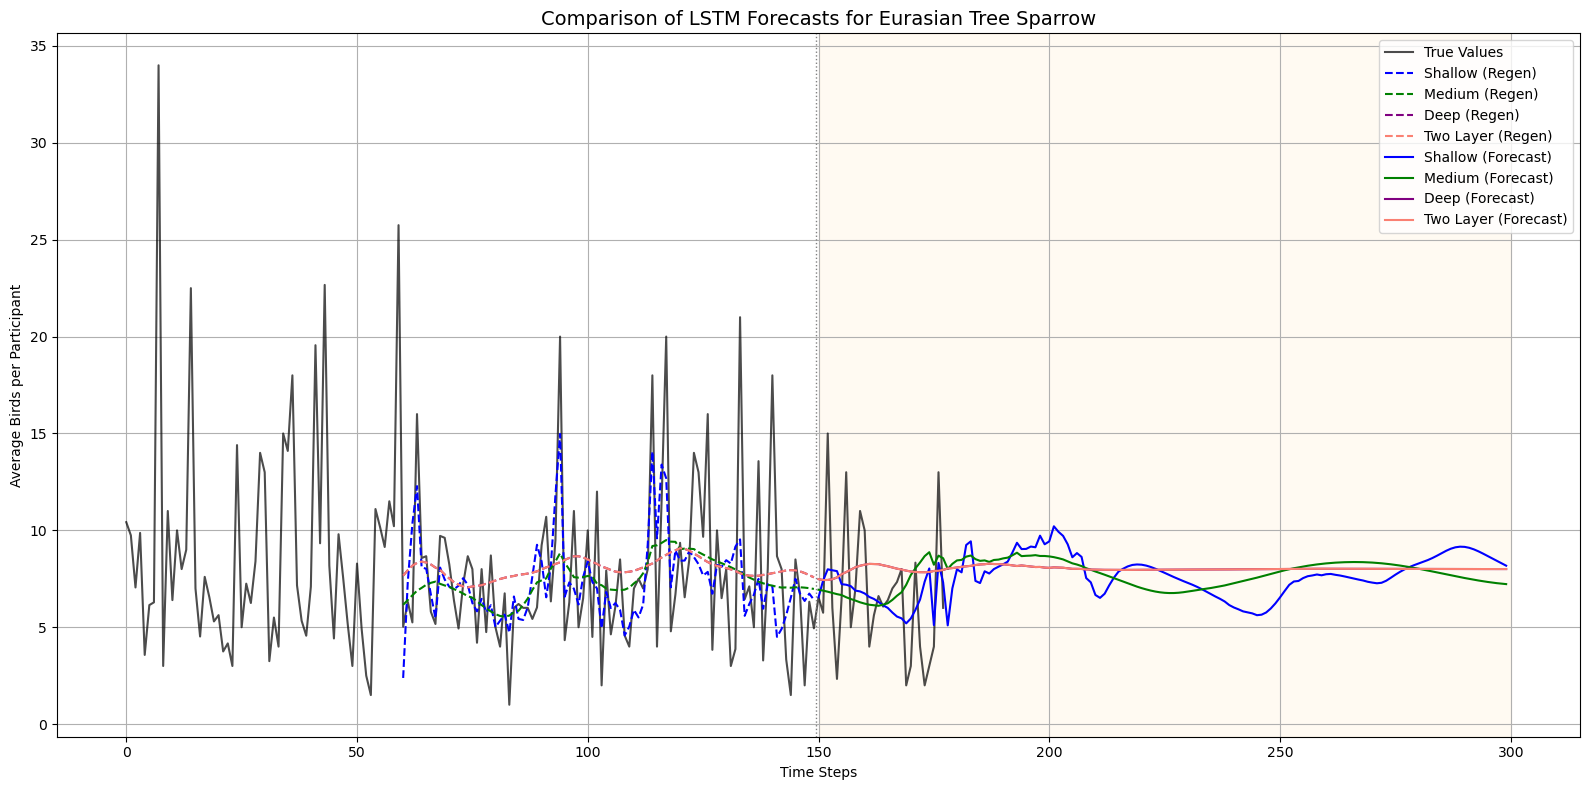

In [ ]:
# Plotting
plt.figure(figsize=(16, 8))
plt.plot(values, label='True Values', color='black', alpha=0.7)

plt.plot(range(window_size, regenerate_points), regen_a[window_size:], '--', label='Shallow (Regen)', color='blue')
plt.plot(range(window_size, regenerate_points), regen_b[window_size:], '--', label='Medium (Regen)', color='green')
plt.plot(range(window_size, regenerate_points), regen_c[window_size:], '--', label='Deep (Regen)', color='purple')
plt.plot(range(window_size, regenerate_points), regen_c[window_size:], '--', label='Two Layer (Regen)', color='salmon')

future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_a, label='Shallow (Forecast)', color='blue')
plt.plot(range(future_start, future_end), future_b, label='Medium (Forecast)', color='green')
plt.plot(range(future_start, future_end), future_c, label='Deep (Forecast)', color='purple')
plt.plot(range(future_start, future_end), future_c, label='Two Layer (Forecast)', color='salmon')

plt.axvline(x=regenerate_points - 0.5, color='gray', linestyle=':', linewidth=1)
plt.axvspan(future_start, future_end, color='orange', alpha=0.05)
plt.title(f'Comparison of LSTM Forecasts for {most_frequent_bird}', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Average Birds per Participant')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


avg_df = pd.read_csv("participants_data2.csv")
avg_df.columns = avg_df.columns.str.strip()
avg_df['Date Created'] = pd.to_datetime(avg_df['Date Created'], format='mixed', dayfirst=True, errors='coerce')

bird_counts = avg_df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[0]
filtered_df = avg_df[avg_df['Bird Name'] == most_frequent_bird]

participants_per_day = filtered_df.groupby('Date Created')['Participant Name'].nunique()
total_birds_per_day = filtered_df.groupby('Date Created')['Number of Birds'].sum()
average_birds_per_participant = total_birds_per_day / participants_per_day

values_avg = average_birds_per_participant.values.astype('float32').reshape(-1, 1)
scaler_avg = MinMaxScaler()
values_scaled_avg = scaler_avg.fit_transform(values_avg)

In [ ]:
# Parameters
window_size = 60
regenerate_points = 150
future_steps = 150

# Create dataset
def create_dataset(data, window_size, forecast_steps=1):
    X, Y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size])
        Y.append(data[i + window_size:i + window_size + forecast_steps])
    return np.array(X), np.array(Y)

# Train and predict function
def train_and_predict(model, model_name, values_scaled, window_size, regenerate_points, future_steps):
    X, Y = create_dataset(values_scaled, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    model.fit(X_train, Y_train, epochs=500, verbose=0, validation_data=(X_test, Y_test))

    regen_pred_actual = []
    for i in range(window_size):
        regen_pred_actual.append(values_scaled[i][0])
    for i in range(regenerate_points - window_size):
        input_window = values_scaled[i:i + window_size].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        regen_pred_actual.append(pred)

    future_input = values_scaled[regenerate_points - window_size:regenerate_points]
    future_predictions = []
    for _ in range(future_steps):
        input_window = future_input[-window_size:].reshape(1, window_size, 1)
        pred = model.predict(input_window, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input[1:], pred)

    regen_pred_actual = scaler_avg.inverse_transform(np.array(regen_pred_actual).reshape(-1, 1))
    future_actual = scaler_avg.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    regen_pred_actual[regen_pred_actual < 0] = 0
    future_actual[future_actual < 0] = 0

    true_values = values_avg[window_size:regenerate_points]
    predicted_values = regen_pred_actual[window_size:regenerate_points]
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = mean_absolute_percentage_error(true_values, predicted_values) * 100

    print(f"\nModel: {model_name}")
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    return regen_pred_actual, future_actual

In [ ]:
# Models
def create_model(units_list):
    model = Sequential()
    for i, units in enumerate(units_list):
        return_seq = i < len(units_list) - 1
        model.add(LSTM(units, return_sequences=return_seq, input_shape=(window_size, 1) if i == 0 else None))
        if i < len(units_list) - 1:
            model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train models
model_a = create_model([64, 32])
model_b = create_model([128, 64, 32])
model_c = create_model([512, 256, 128, 64, 32])
model_d = create_model([128, 64])

regen_a, future_a = train_and_predict(model_a, "Shallow", values_scaled_avg, window_size, regenerate_points, future_steps)
regen_b, future_b = train_and_predict(model_b, "Medium", values_scaled_avg, window_size, regenerate_points, future_steps)
regen_c, future_c = train_and_predict(model_c, "Deep", values_scaled_avg, window_size, regenerate_points, future_steps)
regen_d, future_d = train_and_predict(model_d, "Two-Layer", values_scaled_avg, window_size, regenerate_points, future_steps)

# Train model on total bird count
df_total = pd.read_csv("birds_observation_data_with_index.csv")
df_total['Date Index'] = pd.to_numeric(df_total['Date Index'], errors='coerce')
bird_data_total = df_total[df_total['Bird Name'] == most_frequent_bird]
bird_trend_total = bird_data_total.groupby('Date Index')['Number of Birds'].sum().sort_index()
values_total = bird_trend_total.values.astype('float32').reshape(-1, 1)
values_total_log = np.log1p(values_total)

X_total, Y_total = create_dataset(values_total_log, window_size)
X_total = X_total.reshape((X_total.shape[0], X_total.shape[1], 1))
split = int(len(X_total) * 0.8)
X_train_total, X_test_total = X_total[:split], X_total[split:]
Y_train_total, Y_test_total = Y_total[:split], Y_total[split:]

model_total = create_model([128, 64, 32])
print("\nTraining model on total bird count...")
model_total.fit(X_train_total, Y_train_total, epochs=500, verbose=0, validation_data=(X_test_total, Y_test_total))

# Use total-trained model with avg input
regen_avg_from_total_model = []
for i in range(window_size):
    regen_avg_from_total_model.append(values_scaled_avg[i][0])
for i in range(len(values_scaled_avg) - window_size):
    input_window = np.array(regen_avg_from_total_model[-window_size:]).reshape(1, window_size, 1)
    pred = model_total.predict(input_window, verbose=0)[0, 0]
    regen_avg_from_total_model.append(pred)
regen_avg_from_total_model = scaler_avg.inverse_transform(np.array(regen_avg_from_total_model).reshape(-1, 1))
regen_avg_from_total_model[regen_avg_from_total_model < 0] = 0

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(values_avg, label='True Avg Birds per Participant', color='black', alpha=0.6)
plt.plot(range(window_size, len(regen_a)), regen_a[window_size:], label='Shallow Model', linestyle='--')
plt.plot(range(window_size, len(regen_b)), regen_b[window_size:], label='Medium Model', linestyle='--')
plt.plot(range(window_size, len(regen_c)), regen_c[window_size:], label='Deep Model', linestyle='--')
plt.plot(range(window_size, len(regen_d)), regen_d[window_size:], label='Two-Layer Model', linestyle='--')
plt.plot(range(window_size, len(regen_avg_from_total_model)), regen_avg_from_total_model[window_size:], label='Total-Trained Model on Avg Input', linestyle=':')
plt.title('Average Birds per Participant: True vs Model Predictions')
plt.xlabel('Time Index (Days)')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
